<h1><center>Vietnam Stock Market - Momentum Stategy</center></h1>
<h3><i>Content:</i></h3>
<h3>1. Problem statement</h3>
  <li>What is momentum, mean reversion & seasionality</li>
  <li>Why & How you find it</li>
<h3>2. Data wrangling & EDA</h3>
  <li>Historgram</li>
  <li>Bolinger band, high-low band (breakout)</li>
  <li>View time series/cross sectional for pattern recognition</li>
  <li>Hypothesis refinement</li>
<h3>3. Model construction</h3>
  <p>Candidate selection</p>
  <p>Quantopian zipline & alphalens</p>
  <p>3.1. Risk model</p>
  <p>3.2. Alpha model</p>
  <p>3.3. Multi factor model</p>
<h3>4. Conclusions & Recommendations</h3>

<h2>1. Problem statement</h2>  
<b>Investors will continue to suffer behavioral bias</b>
<p>Vietnam stock exchange is one of the most potential raising up players among frontier markets. The market is in the developing stage and lacking massive & advanced financial tools such as algo-trading (quantitative trading), an alternative of fundamental & technical analysis. Quant-trading analysis three prevaling alpha factors: Momentum, Mean reversion & Seasonality create an initial glance to domestic investors on how the massive trading algorithm from the mature market is able to apply and beating the benchmark in frontier one.</p>

<b>What is momentum</b>  
<p><a href=https://www.investopedia.com/terms/m/momentum.asp>Momentum</a> is the rate of acceleration of a security's price—that is, the speed at which the price is changing. Momentum trading is a strategy that seeks to capitalize on momentum to enter a trend as it is picking up steam.The goal is to work with volatility by finding buying opportunities in short-term uptrends and then sell when the securities start to lose momentum.</p>  
<b>What is mean reversion?</b><br>
<p><a href=https://blog.quantinsti.com/mean-reversion-strategies-introduction-building-blocks/>Mean reversion theory</a> states that security prices and economic indicators such as interest rates will tend to revert to the historical mean prices</p>
<b>What is seasonality?</b><br> 
<b>Why are momentum, mean reversion & seasonality?</b>  
<p>Random walk theory suggests that changes in stock prices have the same distribution and are independent of each other. Stock prices are non-stationary (mean, variance, covariance is changed over time) then it is unlikely able to using the past price to predict the future one. Price is not comparable by time & among stocks</p>
<p> Many of the rationales presented for the strategy’s success fall into one of two behavioral categories: Investors either overreact to important information, or they underreact to it, that leads to momentum effect. Because, after all, we’re only human. (<a href=https://anderson-review.ucla.edu/momentum/>Subrahmanyam</a>) </p>
<p>Finding & modeling patterns (factors) from returns which is more stationary & comparable is the major trend, momentum is one of the most resilent factors</p>
<b>How to find momentum patterns</b>  
<p>Momentum, finance, refers to the capacity for a price trend to sustain itself going forward.</p>
<p>Strong momentum can continue in an upward or downward trend, which can be confirmed by changes in trading volume and other technical indicators.</p>
<p>Momentum investing is a trading strategy in which investors buy securities that are rising and sell them when they look to have peaked.</p>
<p>Momentum trading therefore describes a herding strategy, following others; but price trends are never guaranteed in the future.</p>

<b>To accomplish these tasks, the following steps need to be accomplished: Hypothesis construction; Data wrangling & EDA, Strategy design; Backtesting .</b>  
<b>The data are collected from : </b><a href=https://www.vndirect.com.vn/portal/thong-ke-thi-truong-chung-khoan/lich-su-gia.shtml>vndirect</a>
& <a href=https://s.cafef.vn/Lich-su-giao-dich-VNINDEX-1.chn#data>cafef</a>

### Load Packages

In [46]:
import os
import numpy as np
import pandas as pd
import cvxpy as cvx
import zipline
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import datetime

import functions  
import risk_model_funcs as rmf
import alpha_model_funcs as amf
import multi_factor_funcs as mff
# import visualizations
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 120

<h2>2.  Data wrangling & EDA</h2>  

### Load Data
The data we use for most of the projects is end of day data. This contains data for 621 stocks, but we'll be looking at stocks in the VN100. We also made things a little easier to run by narrowing down our range of time period instead of using all of the data.

In [ ]:
engine = sqlalchemy.create_engine('sqlite:///' + 'vn650')
pd.read_sql('FPT', engine).head(2)
# pd.read_sql('select * from FPT', engine)

date       open       high        low      close  volume  unadjusted  \
0  2006-12-13  19.225752  19.225752  19.225752  19.225752   83530       400.0   
1  2006-12-14  20.187039  20.187039  20.187039  20.187039  280710       420.0   

   putthrough ticker  year  quarter  dividend  
0           0    FPT  2006        4       NaN  
1           0    FPT  2006        4       NaN

In [ ]:
tickers = np.array(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'",engine)).flatten()

In [ ]:
dfs = [pd.read_sql(ticker, engine) for ticker in tickers]

In [ ]:
df = pd.concat(dfs,ignore_index=False)

In [ ]:
df['date'] = pd.to_datetime(df.date)

In [ ]:
df = df.sort_values(by=['date'], ascending=False)

In [ ]:
df = df.set_index('date')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1497337 entries, 2021-11-26 to 2006-03-13
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        1497337 non-null  float64
 1   high        1497337 non-null  float64
 2   low         1497337 non-null  float64
 3   close       1497337 non-null  float64
 4   volume      1497337 non-null  int64  
 5   unadjusted  1497337 non-null  float64
 6   putthrough  1497337 non-null  int64  
 7   ticker      1497337 non-null  object 
 8   year        1497337 non-null  int64  
 9   quarter     1497337 non-null  int64  
 10  dividend    910635 non-null   float64
dtypes: float64(6), int64(4), object(1)
memory usage: 137.1+ MB


In [ ]:
df['simple_return'] = df.groupby('ticker')['close'].pct_change()
df['log_return'] = np.log(1 + df.groupby('ticker')['close'].pct_change())

In [ ]:
df.head(2)

open      high       low     close  volume  unadjusted  \
date                                                                     
2009-12-30  8.132920  8.132920  6.099690  6.912982  140500        17.0   
2009-12-31  7.034976  7.034976  7.034976  7.034976   48900        17.3   

            putthrough ticker  year  quarter  dividend  simple_return  \
date                                                                    
2009-12-30           0    AMV  2009        4       NaN            NaN   
2009-12-31           0    AMV  2009        4       NaN       0.017647   

            log_return  
date                    
2009-12-30         NaN  
2009-12-31    0.017493

In [ ]:
FPT_prices = df[df['ticker'] == 'FPT']['close']
FPT_returns = df[df['ticker'] == 'FPT']['simple_return']
FPT_logreturns = df[df['ticker'] == 'FPT']['log_return']

In [ ]:
fig = go.Figure()
fig.add_traces(go.Scatter(
    name='FPT close price',
    x=FPT_prices.index,
    y=FPT_prices,
    line={'color': 'black'},showlegend=True))
fig.update_layout(title = 'FPT price')

### Histogram

In [ ]:
fig = make_subplots(rows=2, cols=3, column_widths=[0.4,0.4,0.4],row_heights=[0.6,0.6])
  
fig.add_trace(go.Box(x=FPT_prices,name ='Price',marker_color='rgb(16, 154, 246)'),
     row=1, col=1)
fig.add_trace(go.Box(x=FPT_returns,name ='Simple returns',marker_color='rgb(246, 52, 16)'),
    row=1, col=2)
fig.add_trace(go.Box(x=FPT_logreturns,name ='Log returns',marker_color='rgb(0, 0, 255)'),
    row=1, col=3)

fig.add_trace(go.Histogram(x=FPT_prices,
  marker_color='rgb(16, 154, 246)',name ='Price',showlegend=False), 
  row=2, col=1)
fig.add_trace(go.Histogram(x=FPT_returns,
  marker_color='rgb(246, 52, 16)',name ='Simple returns',showlegend=False), 
  row=2, col=2)
fig.add_trace(go.Histogram(x=FPT_logreturns,
  marker_color='rgb(0, 0, 255)',name ='Log returns',showlegend=False), 
  row=2, col=3)
fig.update_layout(height=400, width=1300, title_text='FPT Stock')

### Bolinger band


In [ ]:
df['sma'] = df.close.rolling(window=20).mean()
df['std'] = df.close.rolling(window=20).std()

In [ ]:
df['upper'] = df.sma + 2*df['std']
df['lower'] = df.sma - 2*df['std']

In [ ]:
df['bolinger_buy_signal'] = np.where(df.lower > df.close, True, False)
df['bolinger_sell_signal'] = np.where(df.upper > df.close, True, False)

In [ ]:
df.dropna(subset=['sma'], inplace=True)

In [ ]:
df_bolinger = df[df['ticker'] == 'FPT']

In [ ]:
import plotly.graph_objs as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

def plot_bolinger(prices,title):
    fig = go.Figure()
    layout = go.Layout(title=title)

    fig.add_traces(go.Scatter(
        name='close',
        x=prices.index,
        y=prices.close,
        line={'color': 'black'}))
    fig.add_traces(go.Scatter(
        name='monthly_sma',
        x=prices.index,
        y=prices.sma,
        line={'color': 'red'}))
    fig.add_traces(go.Scatter(
        x=prices.index,
        y=prices.upper,
        name='monthly_bolinger_high_band',
        fill=None,
        line={'color':'#2D3ECF'},showlegend=True))
    fig.add_traces(go.Scatter(
        x=prices.index,
        y=prices.lower,
        name='monthly_bolinger_low_band',
        fill='tonexty',
        fillcolor='rgba(0,250,0,0.3)',
        line={'color': '#B6B2CF'},showlegend=True))

    pyo.iplot({'data': fig, 'layout': layout})


In [ ]:
plot_bolinger(df_bolinger.iloc[3000:],'Bolinger band')

### High-low band (breakout)

In [ ]:
close = df.reset_index().pivot(index='date', columns='ticker', values='close')
high = df.reset_index().pivot(index='date', columns='ticker', values='high')
low = df.reset_index().pivot(index='date', columns='ticker', values='low')

In [ ]:
lookback_days = 20
lookback_high, lookback_low = functions.get_high_lows_lookback(high, low, lookback_days)
visualizations.plot_high_low(
    close['FPT'].iloc[3000:],
    lookback_high['FPT'].iloc[3000:],
    lookback_low['FPT'].iloc[3000:],
    'High and Low of {} Stock'.format('FPT'))

### View time series/cross sectional for pattern recognition

#### Time series analysis
[Momentum Strategy](https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/)

In [ ]:
monthly_close = functions.resample_prices(df['close'])
monthly_returns = functions.compute_log_returns(monthly_close)
prev_returns = functions.shift_returns(monthly_returns, 1)
lookahead_returns = functions.shift_returns(monthly_returns, -1)

In [ ]:
from scipy.stats import linregress

def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

In [ ]:
momentums = close.copy(deep=True)
for ticker in tickers:
    momentums[ticker] = close[ticker].rolling(90).apply(momentum, raw=False)


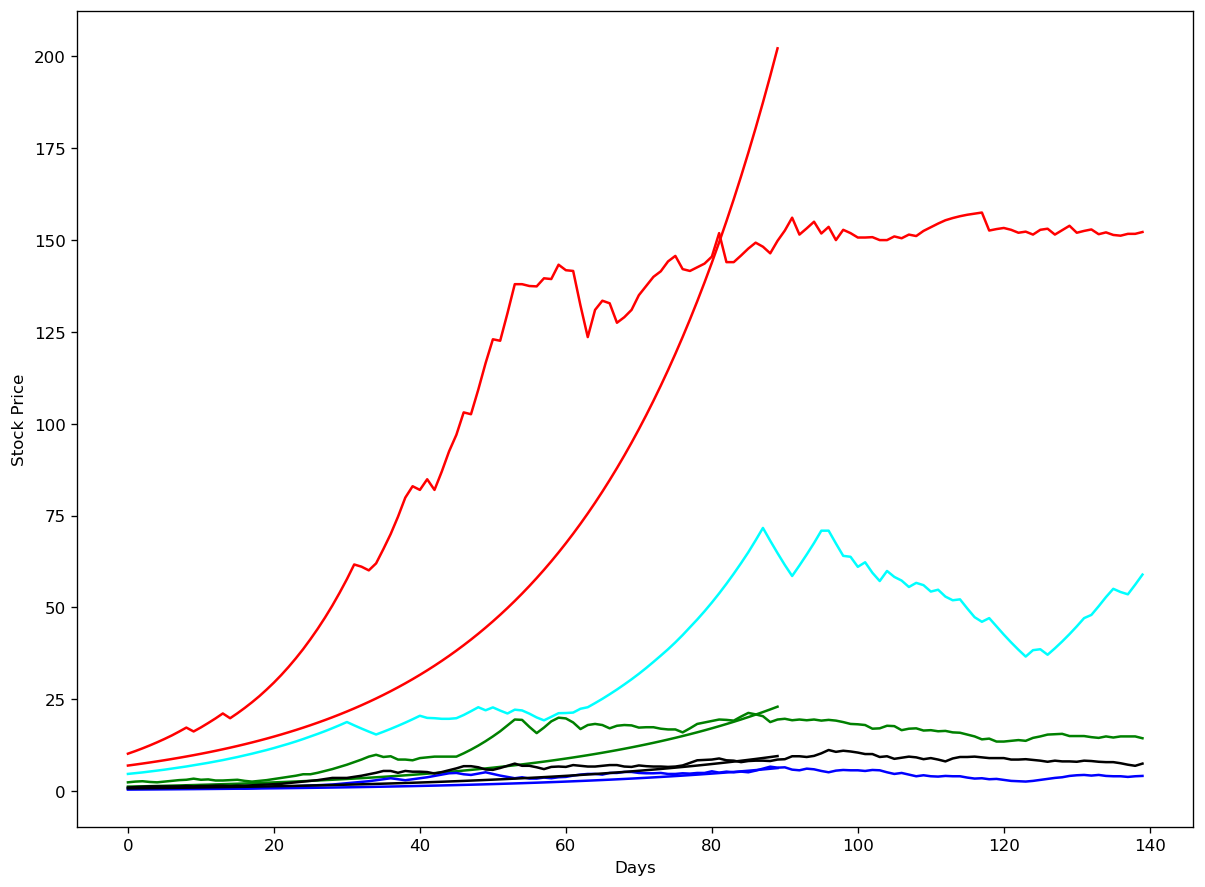

In [ ]:
plt.figure(figsize=(12, 5))
plt.xlabel('Days')
plt.ylabel('Stock Price')
colors = ['red','green','blue','cyan','black']
bests = momentums.max().sort_values(ascending=False).index[:5]
for color, best in zip(colors,bests):
    end = momentums[best].index.get_loc(momentums[best].idxmax())
    rets = np.log(close[best].iloc[end - 90 : end])
    x = np.arange(len(rets)) #90 days
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(140), close[best][end-70:end+70], color=color)
    plt.plot(x, np.e ** (intercept + slope*x), color=color)

#### Cross sectional analysis

In [ ]:
df.set_index('date') # Set the date as the index so we can add the index mean retrun for that day

df['index_mean_simple_return'] =  df.groupby('date')['simple_return'].apply(lambda x: x.mean())#We are using apply here instead of transform because apply can handle grouped outputs 

df['index_mean_log_return'] =  df.groupby('date')['log_return'].apply(lambda x: x.mean())

df['demeaned_return']  = df['simple_return'] - df['index_mean_simple_return']
df['demeaned_log_return']  = df['log_return'] - df['index_mean_log_return']

df.reset_index(inplace=True)#Reset index making the date a column again (lets us use it in calculations)

In [ ]:
df['3m'] = np.log(1 + df.groupby('ticker')['close'].pct_change(periods = 60))
df['12m'] = np.log(1 + df.groupby('ticker')['close'].pct_change(periods = 220))

In [ ]:
df['target-1'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-1)/target)) #One day ahead
df['target-2'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-5)/target)) #One week ahead
df['target-3'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-20)/target)) #One month ahead
df['target-4'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-60)/target)) #One quarter ahead
df['target-5'] = df.groupby('ticker')['close'].transform(lambda target: np.log(target.shift(-120)/target)) #One half ahead

In [ ]:
df.head(2)

index       date      open      high       low     close  volume  \
0      0 2009-12-30  8.132920  8.132920  6.099690  6.912982  140500   
1      1 2009-12-31  7.034976  7.034976  7.034976  7.034976   48900   

   unadjusted  putthrough ticker  ...  index_mean_log_return  demeaned_return  \
0        17.0           0    AMV  ...                    NaN              NaN   
1        17.3           0    AMV  ...                    NaN              NaN   

   demeaned_log_return  3m  12m  target-1  target-2  target-3  target-4  \
0                  NaN NaN  NaN  0.017493  0.132060 -0.131852 -0.152192   
1                  NaN NaN  NaN  0.067064  0.114567 -0.156079 -0.142656   

   target-5  
0 -0.042048  
1 -0.090697  

[2 rows x 26 columns]

In [ ]:
momentum_factor = pd.pivot_table(df,index='3m',values=['target-1','target-2','target-3','target-4','target-5'],aggfunc='mean')

In [ ]:
momentum_factor.head()

target-1  target-2  target-3  target-4  target-5
3m                                                         
-inf            inf       inf       inf       inf       inf
-2.794760  0.063179  0.322399  0.265703  0.083382  0.330242
-2.759343  0.051293  0.351398  0.456758  0.793231  1.044545
-2.724914  0.064220  0.206682  0.189945  0.005089  0.327687
-2.723164 -0.068268  0.189067  0.265872  0.030002  0.209858

In [ ]:
df['3m_bucket'] = functions.bucketing_factors(df['3m'],10)
df['12m_bucket'] = functions.bucketing_factors(df['12m'],10)

<AxesSubplot:title={'center':'Factor of 3m_bucket'}, xlabel='3m_bucket'>

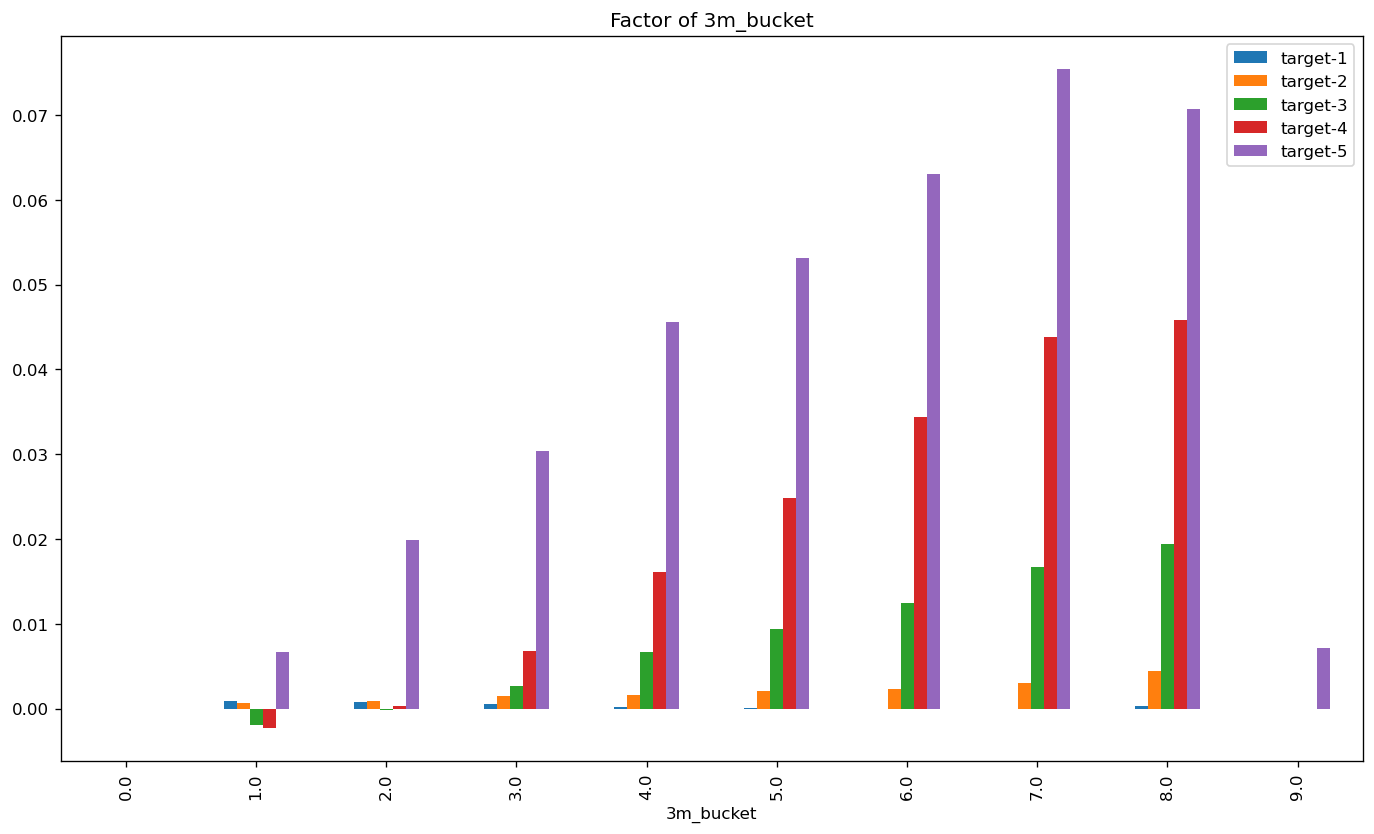

In [ ]:
visualizations.plot_bar(df, '3m_bucket')

<AxesSubplot:title={'center':'Factor of 12m_bucket'}, xlabel='12m_bucket'>

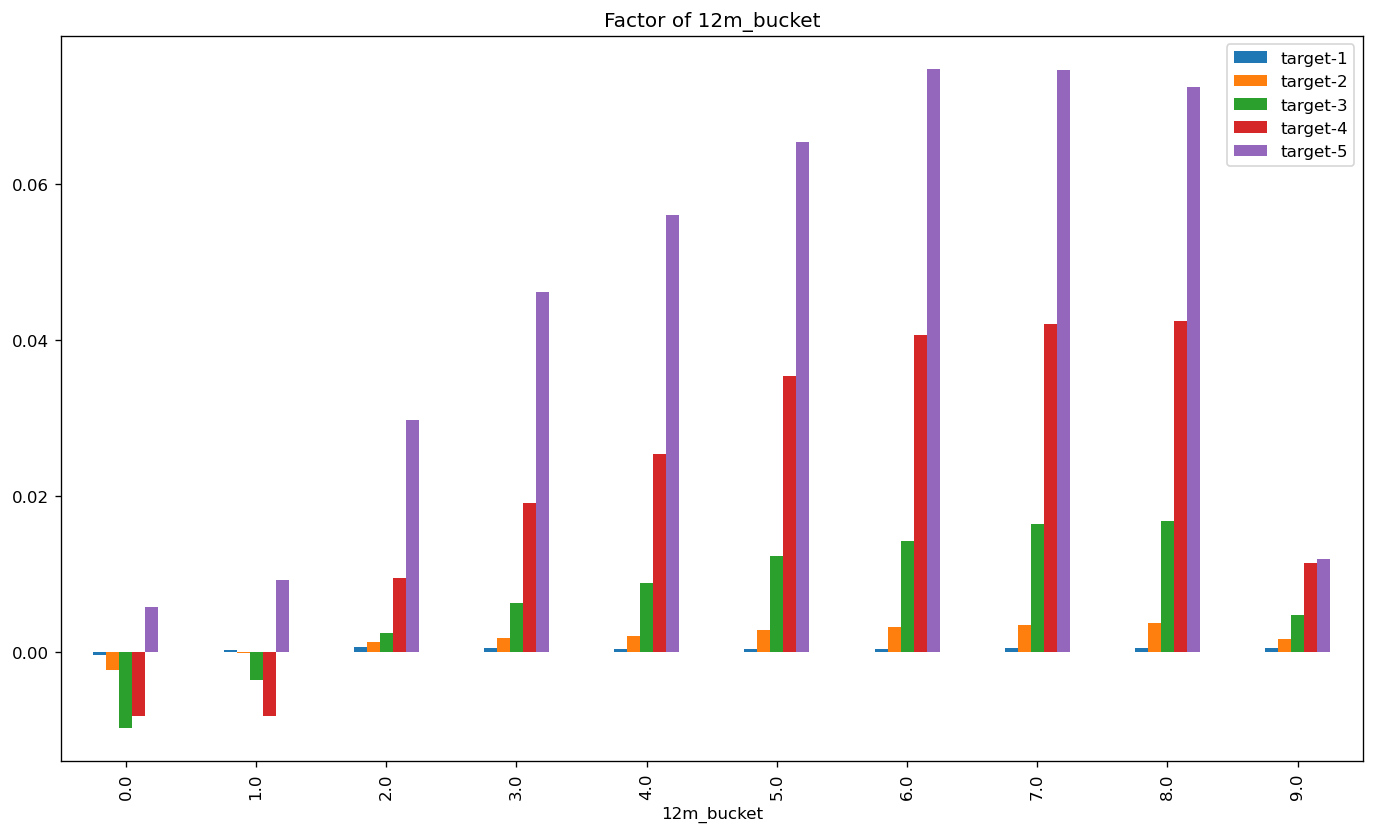

In [ ]:
visualizations.plot_bar(df, '12m_bucket')

In [ ]:
momen_factor_year = pd.pivot_table(df,index=['3m_bucket','year'],values='target-1',aggfunc='mean').reset_index()

In [ ]:
momen_factor_year['annualised'] = momen_factor_year['target-1']*252

In [ ]:
#10 quantiles in 16 years
print(momen_factor_year)

     3m_bucket  year  target-1  annualised
0          0.0  2006  0.000246    0.061890
1          0.0  2007  0.001490    0.375406
2          0.0  2008 -0.005826   -1.468137
3          0.0  2009  0.001976    0.498064
4          0.0  2010       inf         inf
..         ...   ...       ...         ...
155        9.0  2017  0.000474    0.119559
156        9.0  2018 -0.002566   -0.646689
157        9.0  2019 -0.001503   -0.378762
158        9.0  2020 -0.000166   -0.041738
159        9.0  2021  0.002292    0.577613

[160 rows x 4 columns]


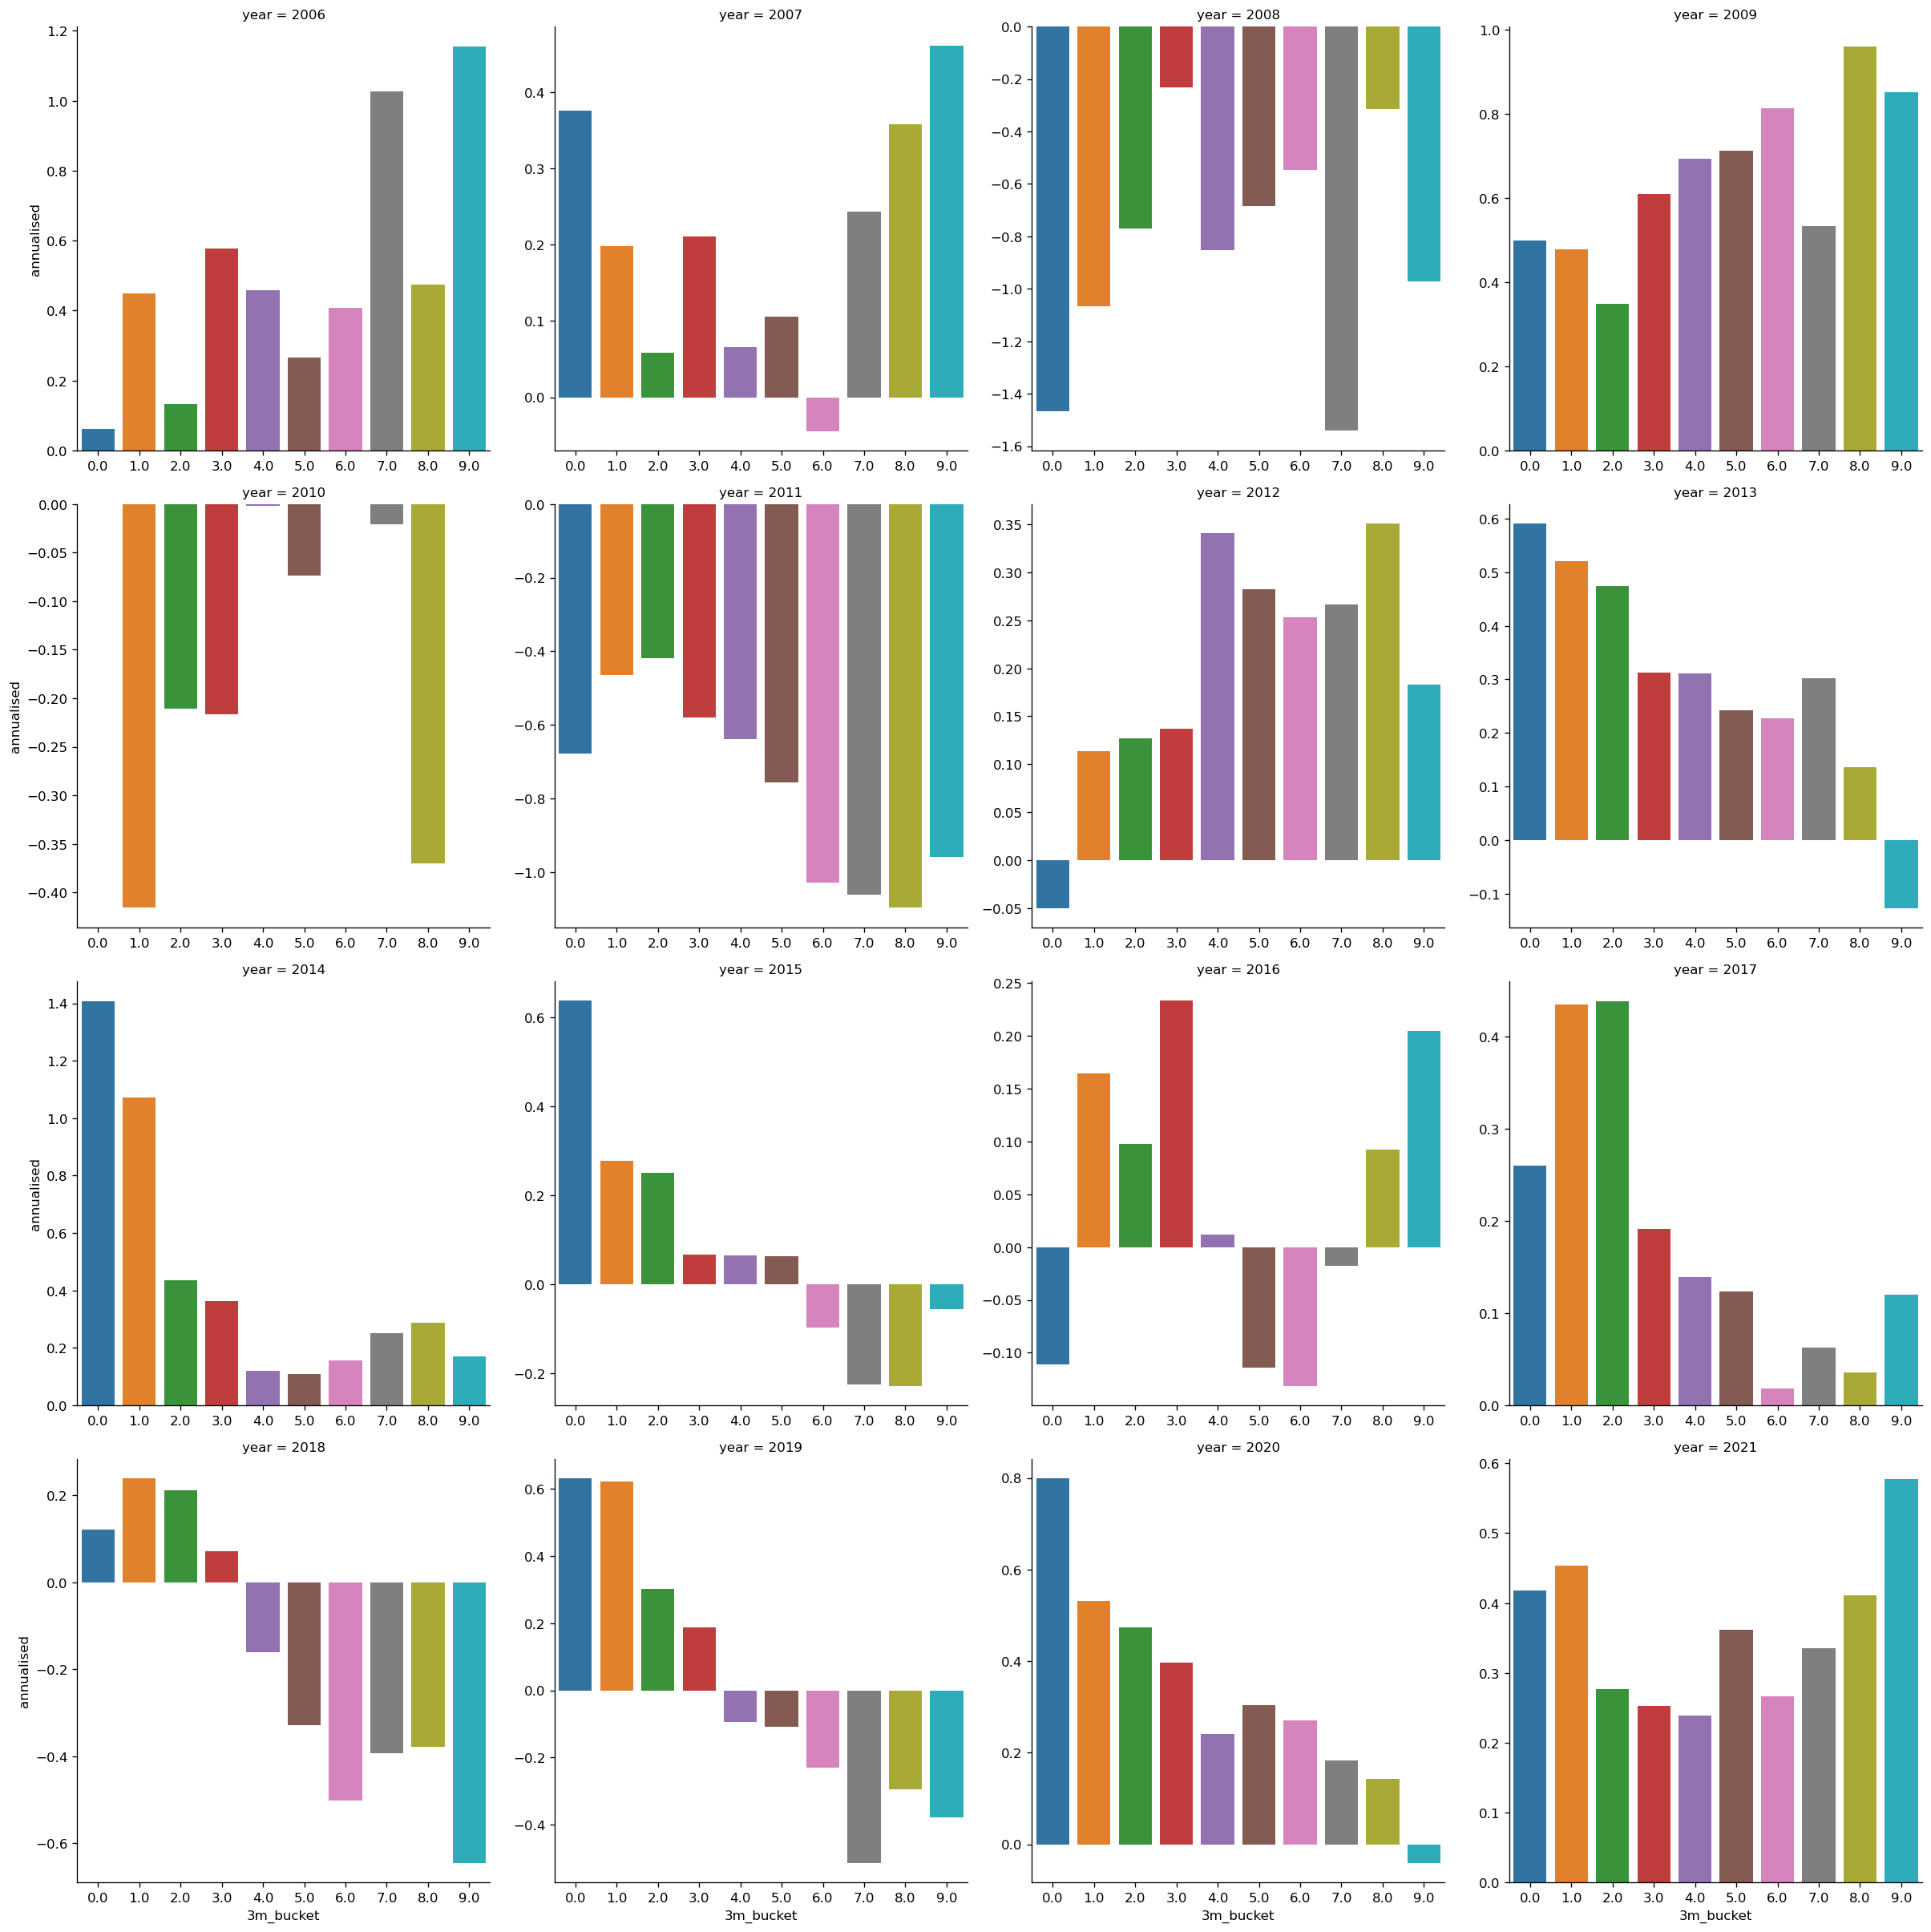

In [ ]:
sns.catplot(x='3m_bucket',y='annualised',data=momen_factor_year,kind='bar',col='year',col_wrap=4,sharey=False,sharex=False);

### Hypothesis refinement

Weekly,monthly, quarterly, halfly & yearly momentum indicators have been observed both in time series & cross sectional analysis, they are considered as the long-term alpha factors. The other indicators such as mean reversion & overnight sentiment - seasonality, both are short-time factors, are also taken into account in the model.

<h2>3. Model construction</h2>

<p>Risk model will be built on stock returns data under CAPM theory to calculate: factor_betas, factor_returns, factor_cov_matrix, idiosyncratic_var_matrix and idiosyncratic_var_vector to compute the portfolio risk. It then will be used as the constrain factors for alpha operation in the weight optimization process of multi-factor model </p>

<p>A typical momentum strategy will buy stocks that have been showing an upward trend in hopes that the trend will continue and sell stocks showing a weak upward trend, even downward one in a specific time window. Momentum indicator is only used for ranking the stocks, not for price prediction.  
Momentum is almost the opposite of the mean-reversion effect, accompany with seasonality as the key resilient factors for alpha model.</p>

<p>Alpha model operating under risk factors & weight scheme influences will be a real-world alpha simulation, from that point investors/trader/portfolio managers can quantitatively design their own strategies & backtests that allows them make up their further decision</p>

### Candidate selection
This is a pretty high level research covering the whole VN stock exchange, so the project will handle 621 exchange-traded stocks, take 10 years historic data from 2011-09-01 to 2021-09-01

<h3>Quantopian zipline & alphalens</h3>
<p>Quantopian is a back testing and implementation system. It allows a user to create a systematic investment strategy in Python, backtest it, and live trade it via a link to Interactive Brokers</p>
<h4>Zipline data ingestion & bundle construction</h4>  
<a href=https://github.com/quantopian/zipline>Zipline</a> - supports both backtesting and live trading:<br>
  - <a href=https://github.com/quantopian/zipline/tree/master/zipline/pipeline>Pipeline</a>:  Real-time streaming sercurities data from database, filtering stock data according to factors.<br>
<a href=https://github.com/quantopian/alphalens>Alphalens</a>:  performance analysis of predictive (alpha) stock factors<br>


##### Data Bundle
bundle file is a python file that defines an ingest function with a specific signature that Zipline uses when running the zipline ingest command
- ingest function:  
  - Format the data  
  - Create the metadata  
  - Write the daily bars  
  - Store the adjustments

We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [2]:
from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar
from zipline.data.data_portal import DataPortal
import functions

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), 'data', 'project_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], 'eod-quotemedia')
bundles.register('eod-quotemedia', ingest_func)

print('Data Registered')

Data Registered


#### Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [3]:
universe = AverageDollarVolume(window_length=120).top(621) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load('eod-quotemedia')
engine = functions.build_pipeline_engine(bundle_data, trading_calendar)

With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [4]:
universe_end_date = pd.Timestamp('2021-09-01', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers[:5]

[Equity(0 [AAA]),
 Equity(1 [AAV]),
 Equity(2 [ABC]),
 Equity(3 [ABI]),
 Equity(4 [ABS])]

#### Get Prices & Returns
Building a data portal from pipeline engine.

In [5]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [6]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

Get daily returns for our risk model using the `get_pricing` function. For this model, we'll be looking back to 5 years of data.

In [7]:
ten_year_prices = get_pricing(
        data_portal,trading_calendar,universe_tickers,
        universe_end_date - pd.DateOffset(years=10),
        universe_end_date)

In [8]:
ten_year_returns = ten_year_prices.pct_change()[1:].fillna(0)
ten_year_returns.tail(2)

Equity(0 [AAA])  Equity(1 [AAV])  Equity(2 [ABC])  \
2021-08-31 00:00:00+00:00         0.002558         0.065728         0.046875   
2021-09-01 00:00:00+00:00         0.033163         0.092511         0.037313   

                           Equity(3 [ABI])  Equity(4 [ABS])  Equity(5 [ABT])  \
2021-08-31 00:00:00+00:00        -0.025487        -0.022222              0.0   
2021-09-01 00:00:00+00:00        -0.007692         0.012626              0.0   

                           Equity(6 [ACB])  Equity(7 [ACC])  Equity(8 [ACE])  \
2021-08-31 00:00:00+00:00        -0.004666         0.009967         0.000000   
2021-09-01 00:00:00+00:00         0.000000         0.013158         0.013514   

                           Equity(9 [ACL])        ...          \
2021-08-31 00:00:00+00:00         0.007782        ...           
2021-09-01 00:00:00+00:00        -0.011583        ...           

                           Equity(611 [VTO])  Equity(612 [VTP])  \
2021-08-31 00:00:00+00:00          -0.027650          -0.004884   
2021-09-01 00:00:00+00:00           0.028436           0.002454   

                           Equity(613 [VTR])  Equity(614 [VXP])  \
2021-08-31 00:00:00+00:00          -0.003311                0.0   
2021-09-01 00:00:00+00:00           0.000000                0.0   

                           Equity(615 [WCS])  Equity(616 [WSB])  \
2021-08-31 00:00:00+00:00           0.011050           0.018367   
2021-09-01 00:00:00+00:00          -0.010929          -0.008016   

                           Equity(617 [X26])  Equity(618 [YBM])  \
2021-08-31 00:00:00+00:00                0.0           0.000000   
2021-09-01 00:00:00+00:00                0.0           0.039437   

                           Equity(619 [YEG])  Equity(620 [YTC])  
2021-08-31 00:00:00+00:00           0.022876                0.0  
2021-09-01 00:00:00+00:00          -0.003195                0.0  

[2 rows x 621 columns]

### 3.1. Statistical Risk Model
Under CAPM theory, let's build a statistical risk model using PCA. So, the first thing is building the PCA model.

In [9]:
import risk_model_funcs as rmf

#### Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

Let's see what the model looks like. First, we'll look at the PCA components.

In [10]:
num_factor_exposures = 20 
pca = rmf.fit_pca(ten_year_returns, num_factor_exposures, 'full') #fit_pca compute factor exposure = pca.component_

pca.components_.shape #20 is num of rows (observations) which is reduced from 1256rows before PCA

(20, 621)

Let's also look at the PCA's percent of variance explained by each factor

<BarContainer object of 20 artists>

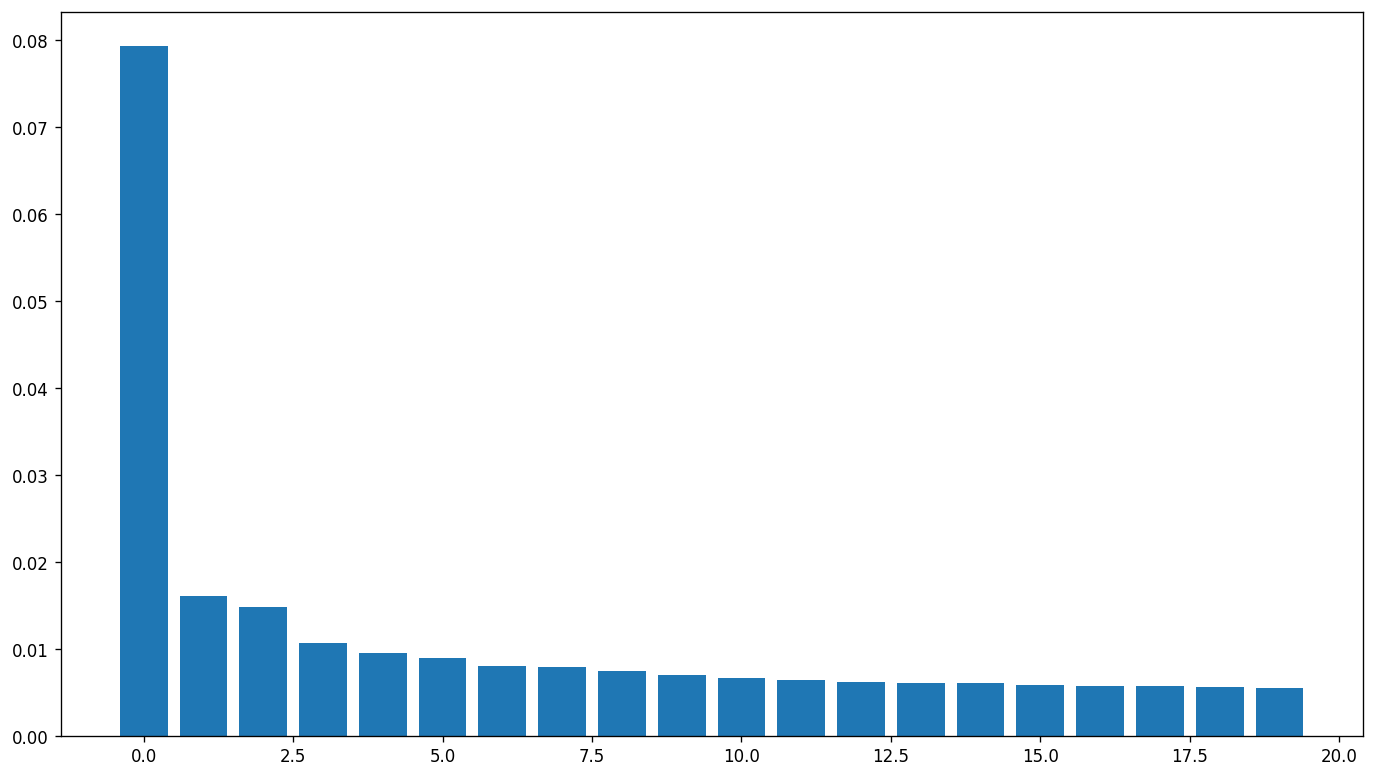

In [11]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

The first factor/principal comonent is dominent. The precise definition of each factor in the latent model is unknown, however we can see the contribution of stocks to each component.

In [12]:
#Find the tickers contribute the most to the first principal component
top5_pc1 = np.argpartition(pca.components_[0], -5)[-5:]
print(top5_pc1,'\n', pca.components_[0][top5_pc1])

[467  59 617  50 491] 
 [0.0019516  0.00210761 0.00657672 0.00284012 0.0024031 ]


In [13]:
ten_year_returns[top5_pc1].columns

Index([Equity(467 [STH]),  Equity(59 [BTV]), Equity(617 [X26]),
        Equity(50 [BPW]), Equity(491 [TDP])],
      dtype='object')

#### Factor Betas (factor exposure)

Implement `factor_betas` to get the factor betas from the PCA model.

In [14]:
#risk_model: factor_betas,factor_returns,factor_cov_matrix,idiosyncratic_var_matrix,idiosyncratic_var_vector
risk_model = {}
#factor_betas(pca, factor_beta_indices, factor_beta_columns)
risk_model['factor_betas'] = rmf.factor_betas(pca, ten_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas'].head(2) # 621(tickers) rows & 20(factors) columns

0         1         2         3         4         5   \
Equity(0 [AAA]) -0.075863 -0.004677  0.002022 -0.033789 -0.009032  0.005992   
Equity(1 [AAV]) -0.024112  0.045659 -0.033518  0.009183 -0.014575 -0.002554   

                       6         7         8         9         10        11  \
Equity(0 [AAA])  0.001046  0.020531  0.022267  0.006952 -0.008712 -0.001285   
Equity(1 [AAV])  0.000264 -0.020054 -0.010048  0.013332  0.009383  0.006218   

                       12        13        14        15        16        17  \
Equity(0 [AAA]) -0.025567 -0.017284  0.001129  0.004876 -0.003481  0.008329   
Equity(1 [AAV])  0.000852  0.025287  0.003902  0.010797  0.019325 -0.014445   

                       18        19  
Equity(0 [AAA]) -0.005341 -0.011347  
Equity(1 [AAV]) -0.012384 -0.018536

#### Factor Returns from asset returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

<AxesSubplot:>

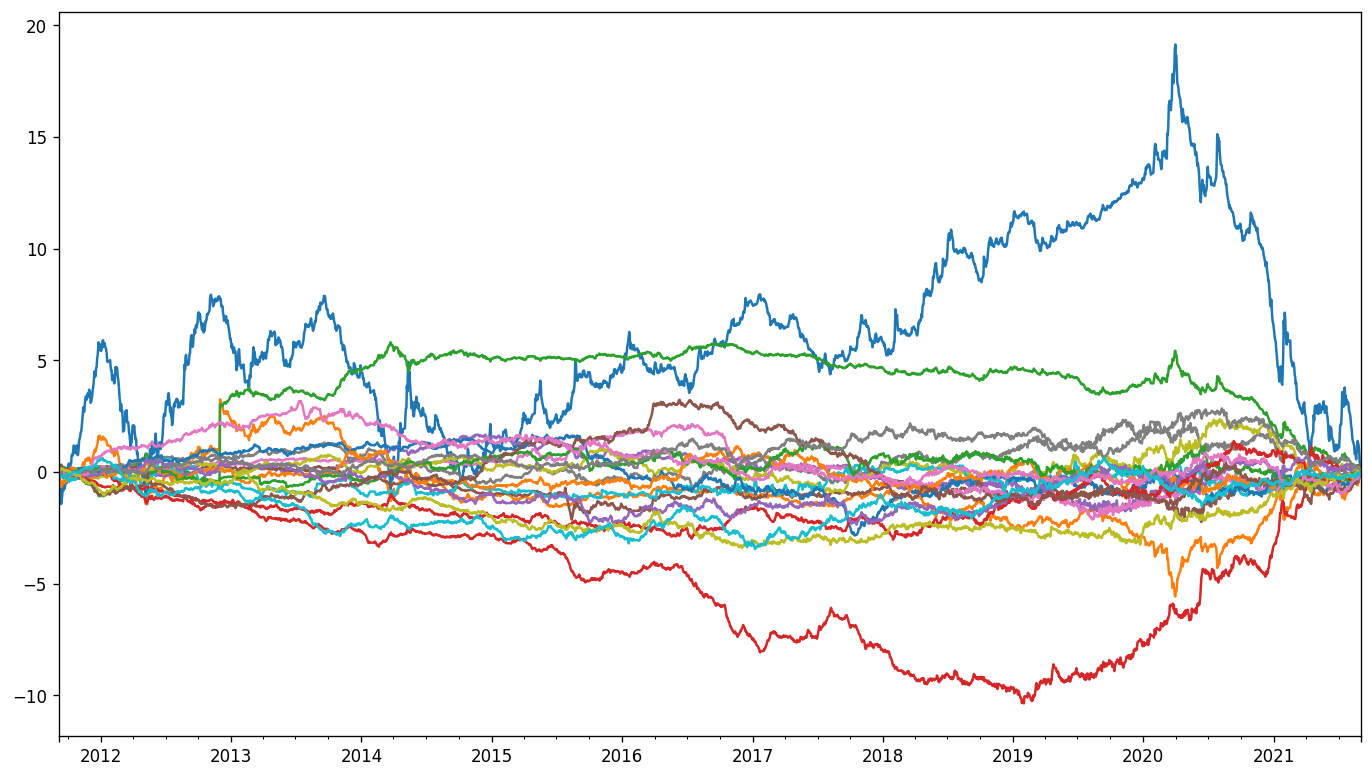

In [15]:
#factor_returns(pca, returns, factor_return_indices, factor_return_columns)
risk_model['factor_returns'] = rmf.factor_returns(
    pca,
    ten_year_returns,
    ten_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None) # 20 PCs (factors) returns by time (1256days)

#### Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [17]:
ann_factor = 252
risk_model['factor_cov_matrix'] = rmf.factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[9.83160205, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 2.00233948, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.83927457, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.33369941, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

In [18]:
np.shape(risk_model['factor_cov_matrix'])

(20, 20)

#### Idiosyncratic Variance Matrix (specific return)
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [19]:
#idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor)
risk_model['idiosyncratic_var_matrix'] = rmf.idiosyncratic_var_matrix(ten_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix'].head(2)

Equity(0 [AAA])  Equity(1 [AAV])  Equity(2 [ABC])  \
Equity(0 [AAA])         0.092997          0.00000              0.0   
Equity(1 [AAV])         0.000000          0.08326              0.0   

                 Equity(3 [ABI])  Equity(4 [ABS])  Equity(5 [ABT])  \
Equity(0 [AAA])              0.0              0.0              0.0   
Equity(1 [AAV])              0.0              0.0              0.0   

                 Equity(6 [ACB])  Equity(7 [ACC])  Equity(8 [ACE])  \
Equity(0 [AAA])              0.0              0.0              0.0   
Equity(1 [AAV])              0.0              0.0              0.0   

                 Equity(9 [ACL])        ...          Equity(611 [VTO])  \
Equity(0 [AAA])              0.0        ...                        0.0   
Equity(1 [AAV])              0.0        ...                        0.0   

                 Equity(612 [VTP])  Equity(613 [VTR])  Equity(614 [VXP])  \
Equity(0 [AAA])                0.0                0.0                0.0   
Equity(1 [AAV])                0.0                0.0                0.0   

                 Equity(615 [WCS])  Equity(616 [WSB])  Equity(617 [X26])  \
Equity(0 [AAA])                0.0                0.0                0.0   
Equity(1 [AAV])                0.0                0.0                0.0   

                 Equity(618 [YBM])  Equity(619 [YEG])  Equity(620 [YTC])  
Equity(0 [AAA])                0.0                0.0                0.0  
Equity(1 [AAV])                0.0                0.0                0.0  

[2 rows x 621 columns]

#### Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [20]:
#idiosyncratic_var_vector(returns, idiosyncratic_var_matrix)
risk_model['idiosyncratic_var_vector'] = rmf.idiosyncratic_var_vector(ten_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector'].head(2)

0
Equity(0 [AAA])  0.092997
Equity(1 [AAV])  0.083260

#### Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

Let's see what the portfolio risk would be if we had even weights across all stocks.

In [21]:
#assume equal weight for every stock
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

#predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights)
rmf.predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.10517001637803534

<h3>3.3. Alpha model</h3>

In [26]:
import alpha_model_funcs as amf

### Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year, 1 Half Year, 1 Quarter, 1 Month, 1 Week Factors
- Mean Reversion 5Days, 20Days Sector Neutral Factors
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor  

Each factor will have a hypothesis that goes with it. 

#### Momentum Factors
Momentum function uses the returns data from `universe` (621 tickers), they are demeaned by sector, ranking, then converted to a zscore:  
- Yearly momentum hypothesis: it is "Higher past 12-months (252 days) returns are proportional to future return." 
- Halfly momentum hypothesis: it is "Higher past 6-months (120 days) returns are proportional to future return." 
- Quarterly momentum hypothesis: it is "Higher past 3-months (60 days) returns are proportional to future return." 
- Monthly momentum hypothesis: it is "Higher past 1-month (20 days) returns are proportional to future return." 
- Weekly momentum hypothesis: it is "Higher past 1-week (5 days) returns are proportional to future return." 

#### Mean Reversion Factors
Mean reversion theory states that security prices and economic indicators such as interest rates will tend to revert to the historical mean prices.  
- Mean_reversion_5day hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe` (621 tickers), ranking, then converted to a zscore.  
- Mean_reversion_5days_smoothed is a smoothed version of Mean_reversion_5day factor using `SimpleMovingAverage` function. It is also applied rank and zscore again.
- Mean_reversion_20day hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe` (621 tickers), ranking, then converted to a zscore.

#### Seasonality Factors
Numerous traders have noticed that the US stocks have significantly higher return during the night session compared to the daily session. Multiple academic studies have confirmed this suspicion and found that the US equity premium is mostly due to overnight returns. This notion is called an [overnight anomaly](https://quantpedia.com/market-sentiment-and-an-overnight-anomaly/)  
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).
- Overnight Sentiment
- Overnight Sentiment Smoothed

#### Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

For calculating factors, we'll be looking back 5 years.

**Note:** _The last day of the data (2021-09-01) is usually a public holiday in VN, Going back 5 years might fall on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days (August has no public holiday) to fall on the next day when the market is open._

In [22]:
universe = AverageDollarVolume(window_length=120).top(621)
factor_start_date = universe_end_date - pd.DateOffset(years=5, days=2)
sector = functions.Sector()

In [27]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    amf.momentum(252, universe),
    'Momentum_1YR')
pipeline.add(
    amf.momentum(5, universe),
    'Momentum_1WK')
pipeline.add(
    amf.momentum(20, universe),
    'Momentum_1MNT')
pipeline.add(
    amf.momentum(60, universe),
    'Momentum_1QTR')
pipeline.add(
    amf.momentum(120, universe),
    'Momentum_1HLF')
pipeline.add(
    amf.mean_reversion(5, universe),
    'Mean_Reversion_5Day')
pipeline.add(
    amf.mean_reversion_smoothed(5, universe),
    'Mean_Reversion_5Day_Smoothed')
pipeline.add(
    amf.overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    amf.overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])             0.913481   
                          Equity(1 [AAV])                  NaN   
                          Equity(2 [ABC])             0.225404   
                          Equity(3 [ABI])             0.288676   
                          Equity(4 [ABS])                  NaN   

                                           Mean_Reversion_5Day_Smoothed  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])                      0.636669   
                          Equity(1 [AAV])                           NaN   
                          Equity(2 [ABC])                      1.593649   
                          Equity(3 [ABI])                      0.423128   
                          Equity(4 [ABS])                           NaN   

                                           Momentum_1HLF  Momentum_1MNT  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])       1.670343      -0.047781   
                          Equity(1 [AAV])            NaN            NaN   
                          Equity(2 [ABC])            NaN            NaN   
                          Equity(3 [ABI])       1.151961       0.342429   
                          Equity(4 [ABS])            NaN            NaN   

                                           Momentum_1QTR  Momentum_1WK  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])       1.438009     -0.913481   
                          Equity(1 [AAV])            NaN           NaN   
                          Equity(2 [ABC])            NaN     -0.225404   
                          Equity(3 [ABI])       0.696850     -0.288676   
                          Equity(4 [ABS])            NaN           NaN   

                                           Momentum_1YR  Overnight_Sentiment  \
2016-08-30 00:00:00+00:00 Equity(0 [AAA])      1.667588             0.797693   
                          Equity(1 [AAV])           NaN            -0.502044   
                          Equity(2 [ABC])           NaN            -1.193750   
                          Equity(3 [ABI])      1.108860             1.489398   
                          Equity(4 [ABS])           NaN            -0.496466   

                                           Overnight_Sentiment_Smoothed  
2016-08-30 00:00:00+00:00 Equity(0 [AAA])                      0.546671  
                          Equity(1 [AAV])                     -0.803271  
                          Equity(2 [ABC])                     -0.384901  
                          Equity(3 [ABI])                     -0.407214  
                          Equity(4 [ABS])                     -0.792114

### Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_

In [ ]:
universe_end_date = pd.Timestamp('2021-09-01', tz='UTC')
factor_start_date = universe_end_date - pd.DateOffset(years=5, days=2)

In [28]:
assets = all_factors.index.levels[1].values.tolist() # get index from alpha fattors
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets, 
    factor_start_date,
    universe_end_date)

In [3]:
pricing = pd.read_csv('./data/al_pricing.csv', index_col=[0],skipinitialspace=True)

In [4]:
pricing.index = pd.to_datetime(pricing.index).tz_localize('UTC')
pricing.index

DatetimeIndex(['2016-08-31', '2016-09-01', '2016-09-02', '2016-09-06',
               '2016-09-07', '2016-09-08', '2016-09-09', '2016-09-12',
               '2016-09-13', '2016-09-14',
               ...
               '2021-08-19', '2021-08-20', '2021-08-23', '2021-08-24',
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-30',
               '2021-08-31', '2021-09-01'],
              dtype='datetime64[ns, UTC]', length=1261, freq=None)

In [5]:
pricing.head(2)

Equity(0 [AAA])  Equity(1 [AAV])  Equity(2 [ABC])  \
2016-08-31 00:00:00+00:00            17.38              NaN            16.04   
2016-09-01 00:00:00+00:00            17.43              NaN            16.09   

                           Equity(3 [ABI])  Equity(4 [ABS])  Equity(5 [ABT])  \
2016-08-31 00:00:00+00:00            15.18              NaN            34.34   
2016-09-01 00:00:00+00:00            14.94              NaN            34.34   

                           Equity(6 [ACB])  Equity(7 [ACC])  Equity(8 [ACE])  \
2016-08-31 00:00:00+00:00             6.14            15.32            18.15   
2016-09-01 00:00:00+00:00             6.10            15.07            18.88   

                           Equity(9 [ACL])        ...          \
2016-08-31 00:00:00+00:00             3.66        ...           
2016-09-01 00:00:00+00:00             3.66        ...           

                           Equity(611 [VTO])  Equity(612 [VTP])  \
2016-08-31 00:00:00+00:00               6.18                NaN   
2016-09-01 00:00:00+00:00               6.12                NaN   

                           Equity(613 [VTR])  Equity(614 [VXP])  \
2016-08-31 00:00:00+00:00                NaN                NaN   
2016-09-01 00:00:00+00:00                NaN                NaN   

                           Equity(615 [WCS])  Equity(616 [WSB])  \
2016-08-31 00:00:00+00:00              98.13              26.97   
2016-09-01 00:00:00+00:00              98.13              26.66   

                           Equity(617 [X26])  Equity(618 [YBM])  \
2016-08-31 00:00:00+00:00                NaN                NaN   
2016-09-01 00:00:00+00:00                NaN                NaN   

                           Equity(619 [YEG])  Equity(620 [YTC])  
2016-08-31 00:00:00+00:00                NaN                NaN  
2016-09-01 00:00:00+00:00                NaN                NaN  

[2 rows x 621 columns]

In [6]:
all_factors = pd.read_csv('./data/all_factors.csv', index_col=[0,1],skipinitialspace=True) 
all_factors.index.set_names('', level=1,inplace=True)
all_factors.index = all_factors.index.set_levels(
    [pd.to_datetime(all_factors.index.levels[0]).tz_localize('UTC'),\
                                                all_factors.index.levels[1]])

In [7]:
all_factors.index.levels[0]

DatetimeIndex(['2016-08-30', '2016-08-31', '2016-09-01', '2016-09-02',
               '2016-09-06', '2016-09-07', '2016-09-08', '2016-09-09',
               '2016-09-12', '2016-09-13',
               ...
               '2021-08-19', '2021-08-20', '2021-08-23', '2021-08-24',
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-30',
               '2021-08-31', '2021-09-01'],
              dtype='datetime64[ns, UTC]', length=1262, freq=None)

In [8]:
all_factors.head(2)

Mean_Reversion_20Day_Sector_Neutral  \
                                                                                 
2016-08-30 00:00:00+00:00 Equity(0 [AAA])                            -0.278722   
                          Equity(1 [AAV])                                  NaN   

                                           Mean_Reversion_5Day_Sector_Neutral  \
                                                                                
2016-08-30 00:00:00+00:00 Equity(0 [AAA])                            0.383583   
                          Equity(1 [AAV])                                 NaN   

                                           Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
                                                                                         
2016-08-30 00:00:00+00:00 Equity(0 [AAA])                                    -0.098862   
                          Equity(1 [AAV])                                          NaN   

                                           Momentum_1HLF  Momentum_1MTH  \
                                                                          
2016-08-30 00:00:00+00:00 Equity(0 [AAA])       1.670343       0.278722   
                          Equity(1 [AAV])            NaN            NaN   

                                           Momentum_1QTR  Momentum_1WK  \
                                                                         
2016-08-30 00:00:00+00:00 Equity(0 [AAA])       1.429953     -0.383583   
                          Equity(1 [AAV])            NaN           NaN   

                                           Momentum_1YR  Overnight_Sentiment  \
                                                                               
2016-08-30 00:00:00+00:00 Equity(0 [AAA])      1.676183             0.797693   
                          Equity(1 [AAV])           NaN            -0.502044   

                                           Overnight_Sentiment_Smoothed  
                                                                         
2016-08-30 00:00:00+00:00 Equity(0 [AAA])                      0.546671  
                          Equity(1 [AAV])                     -0.803271

#### Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. 

In [9]:
import alphalens as al

#convert factors & prices to alphalen data format, return A MultiIndex Series (DF)
##indexed by date (level 0) and asset (level 1)...https://quantopian.github.io/alphalens/alphalens.html
#calculate 1day returns, 1day factor returns & classify to quantiles
clean_factor_data = { 
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

#convert y-m-d index format to seconds 
unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 17.0% entries from factor data: 17.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 16.5% entries from factor data: 16.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 13.2% entries from factor data: 13.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 19.3% entries from factor data: 19.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 17.0% entries from factor data: 17.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropp

#### Quantile Analysis
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

In [10]:
clean_factor_data['Mean_Reversion_5Day_Sector_Neutral'].head(2)

1D    factor  factor_quantile
date                      asset                                               
2016-08-31 00:00:00+00:00 Equity(0 [AAA])  0.002877  0.565488                4
                          Equity(2 [ABC])  0.003117 -0.114679                3

In [12]:
clean_factor_data['Mean_Reversion_5Day_Sector_Neutral'].loc[pd.IndexSlice['2019-08-30 00:00:00+00:00',:]].head()

1D    factor  factor_quantile
date                      asset                                               
2019-08-30 00:00:00+00:00 Equity(0 [AAA]) -0.027170  1.643886                5
                          Equity(1 [AAV]) -0.017801 -0.927175                2
                          Equity(2 [ABC])  0.031891 -0.841852                2
                          Equity(3 [ABI]) -0.006565 -1.177455                1
                          Equity(5 [ABT])  0.000000 -0.893045                2

In [13]:
unixt_factor_data['Mean_Reversion_5Day_Sector_Neutral'].loc[pd.IndexSlice[[1567468800.00000000],:]].head()

1D    factor  factor_quantile
date         asset                                               
1.567469e+09 Equity(0 [AAA]) -0.003103  1.126261                5
             Equity(1 [AAV]) -0.018124 -1.422047                1
             Equity(2 [ABC]) -0.030905  0.119452                3
             Equity(3 [ABI]) -0.045217 -1.461864                1
             Equity(5 [ABT]) -0.012832  0.358356                4

In [14]:
ls_factor_returns = pd.DataFrame()

#Computes period wise returns for portfolio weighted by factor values
for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

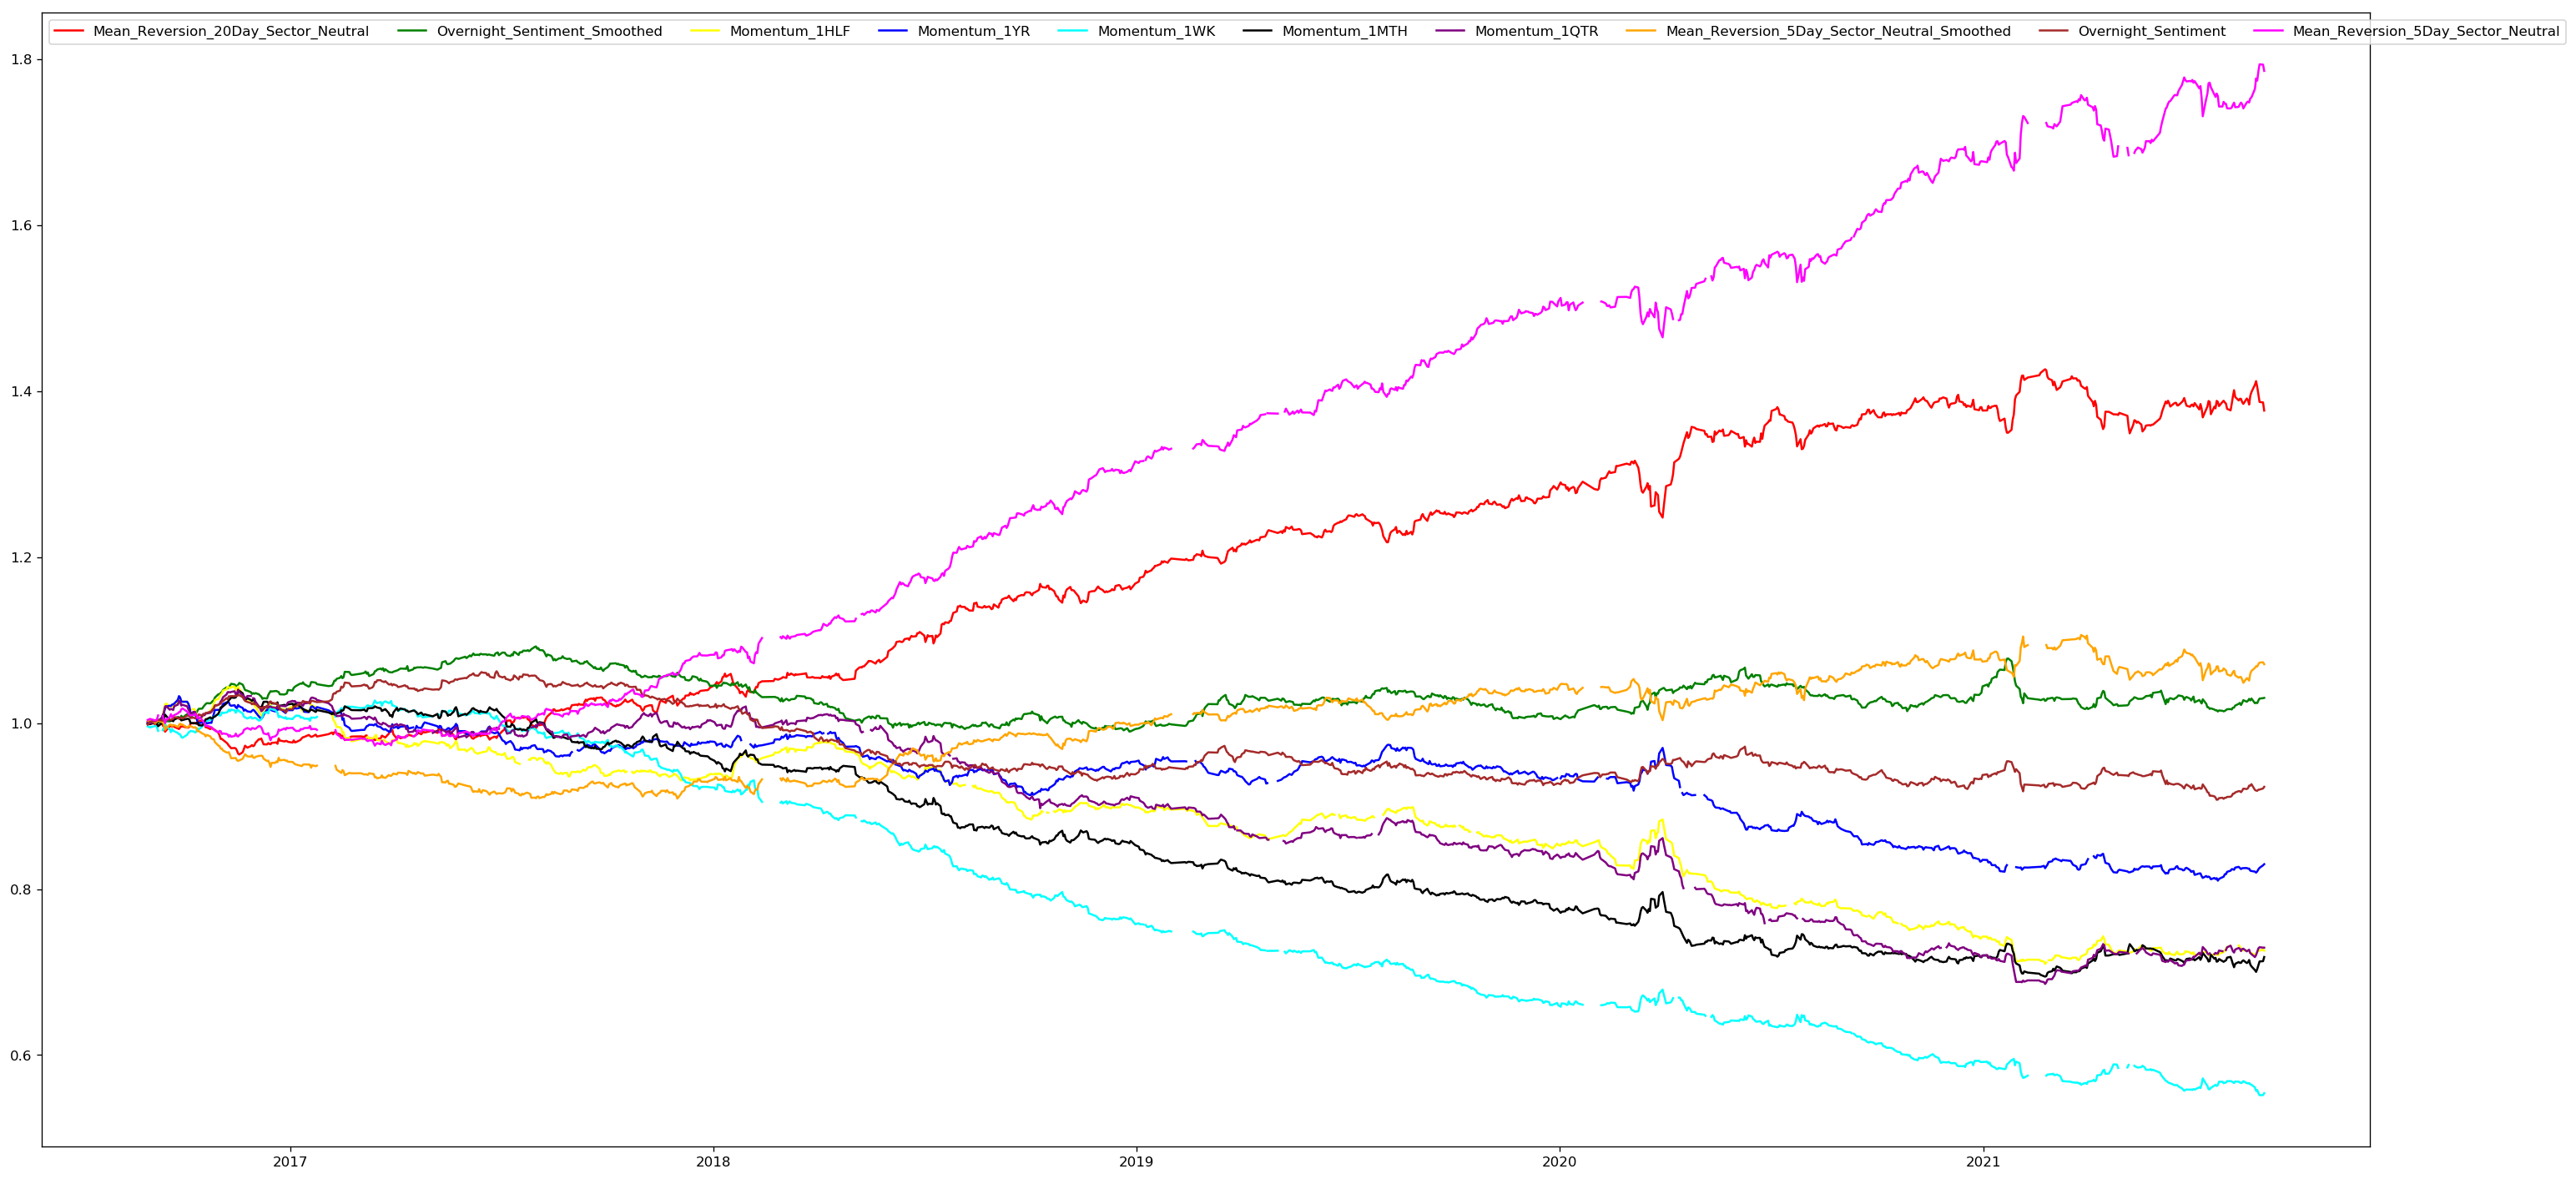

In [15]:
colors = ['red','green','yellow','blue','cyan','black','purple','orange','brown','magenta']
plt.figure(figsize=(30, 15))
for i, col in enumerate(ls_factor_returns.columns):
  plt.plot((1+ls_factor_returns[col]).cumprod(),color=colors[i])
plt.legend(ls_factor_returns.columns,loc="upper left",ncol=len(ls_factor_returns.columns),title_fontsize=20)
plt.show()

In [16]:
ls_factor_returns.head(2)

Mean_Reversion_20Day_Sector_Neutral  \
date                                                             
2016-08-31 00:00:00+00:00                             0.000359   
2016-09-02 00:00:00+00:00                             0.000930   

                           Overnight_Sentiment_Smoothed  Momentum_1HLF  \
date                                                                     
2016-08-31 00:00:00+00:00                     -0.000680       0.002097   
2016-09-02 00:00:00+00:00                      0.001722      -0.002243   

                           Momentum_1YR  Momentum_1WK  Momentum_1MTH  \
date                                                                   
2016-08-31 00:00:00+00:00      0.001313     -0.003843      -0.000359   
2016-09-02 00:00:00+00:00      0.000789     -0.001277      -0.000930   

                           Momentum_1QTR  \
date                                       
2016-08-31 00:00:00+00:00       0.000776   
2016-09-02 00:00:00+00:00      -0.001016   

                           Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
date                                                                     
2016-08-31 00:00:00+00:00                                     0.002977   
2016-09-02 00:00:00+00:00                                    -0.000362   

                           Overnight_Sentiment  \
date                                             
2016-08-31 00:00:00+00:00            -0.001858   
2016-09-02 00:00:00+00:00             0.003700   

                           Mean_Reversion_5Day_Sector_Neutral  
date                                                           
2016-08-31 00:00:00+00:00                            0.003843  
2016-09-02 00:00:00+00:00                            0.001277

#### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

In [17]:
qr_factor_returns = pd.DataFrame()

#Computes mean returns for factor quantiles across provided forward returns columns
for factor, factor_data in unixt_factor_data.items():
    #get mean returns of each quantile through the time
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205F7FB21D0>,
      dtype=object)

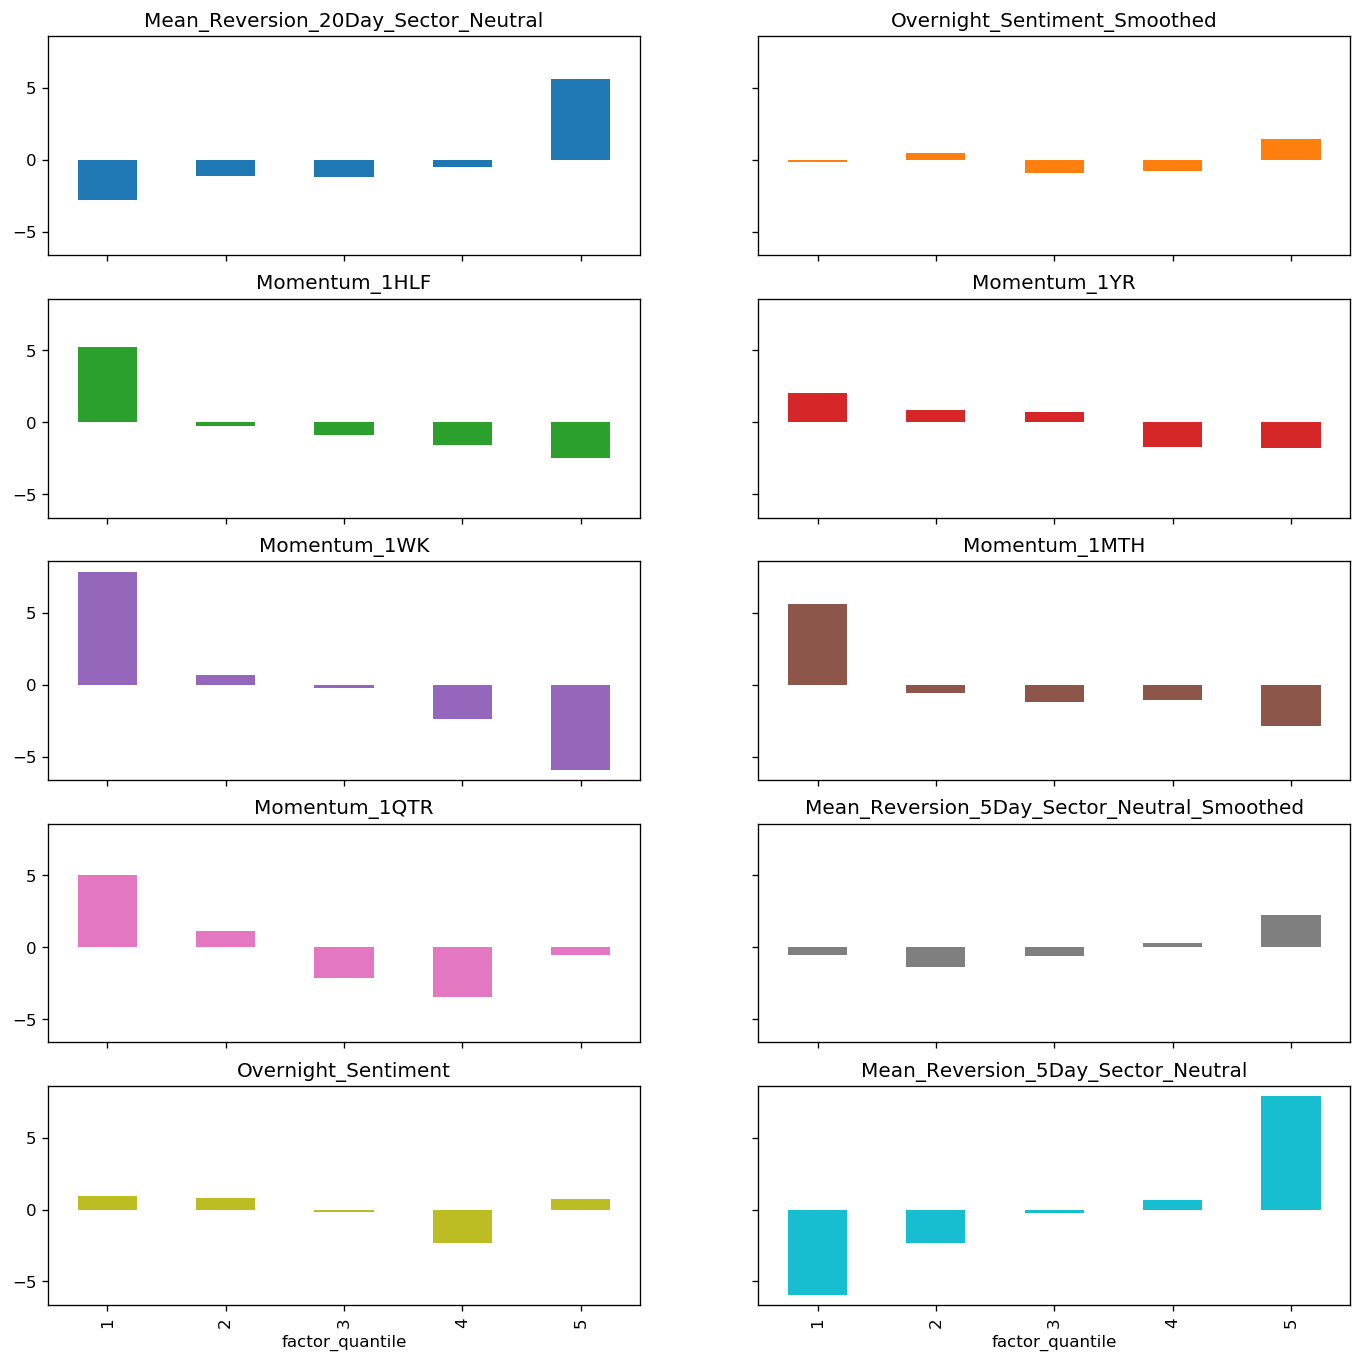

In [28]:
# colors = ['red','green','yellow','blue','cyan','black','purple','orange','brown','magenta']
(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,2),
    figsize=(14, 14),
    legend=False)

In [33]:
best_quantile = {}

#Filter the best quantiles by factors that contain target stocks for trading
for factor, factor_data in clean_factor_data.items():
    #get time & ticker by best quantile    
    if factor == 'Mean_Reversion_5Day_Sector_Neutral':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Mean_Reversion_5Day_Sector_Neutral_Smoothed':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Mean_Reversion_20Day_Sector_Neutral':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Overnight_Sentiment':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Overnight_Sentiment_Smoothed':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Momentum_1HLF':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Momentum_1MTH':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 5].index.values.tolist()
    if factor == 'Momentum_1QTR':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Momentum_1WK':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    if factor == 'Momentum_1YR':
        best_quantile[factor] = factor_data[factor_data['factor_quantile'] == 1].index.values.tolist()
    

In [34]:
len(best_quantile['Mean_Reversion_5Day_Sector_Neutral']),len(best_quantile['Momentum_1MTH']),len(best_quantile['Momentum_1YR']),len(best_quantile['Overnight_Sentiment_Smoothed'])

(131137, 130300, 122950, 139199)

In [35]:
ls_factor_returns_quantile = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    if factor == 'Mean_Reversion_5Day_Sector_Neutral':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Mean_Reversion_5Day_Sector_Neutral_Smoothed':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Mean_Reversion_20Day_Sector_Neutral':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Overnight_Sentiment':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Overnight_Sentiment_Smoothed':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 5]).iloc[:, 0]
    if factor == 'Momentum_1HLF':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]
    if factor == 'Momentum_1MTH':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]
    if factor == 'Momentum_1QTR':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]
    if factor == 'Momentum_1WK':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]
    if factor == 'Momentum_1YR':
        ls_factor_returns_quantile[factor] = al.performance.factor_returns(factor_data[factor_data['factor_quantile'] == 1]).iloc[:, 0]    

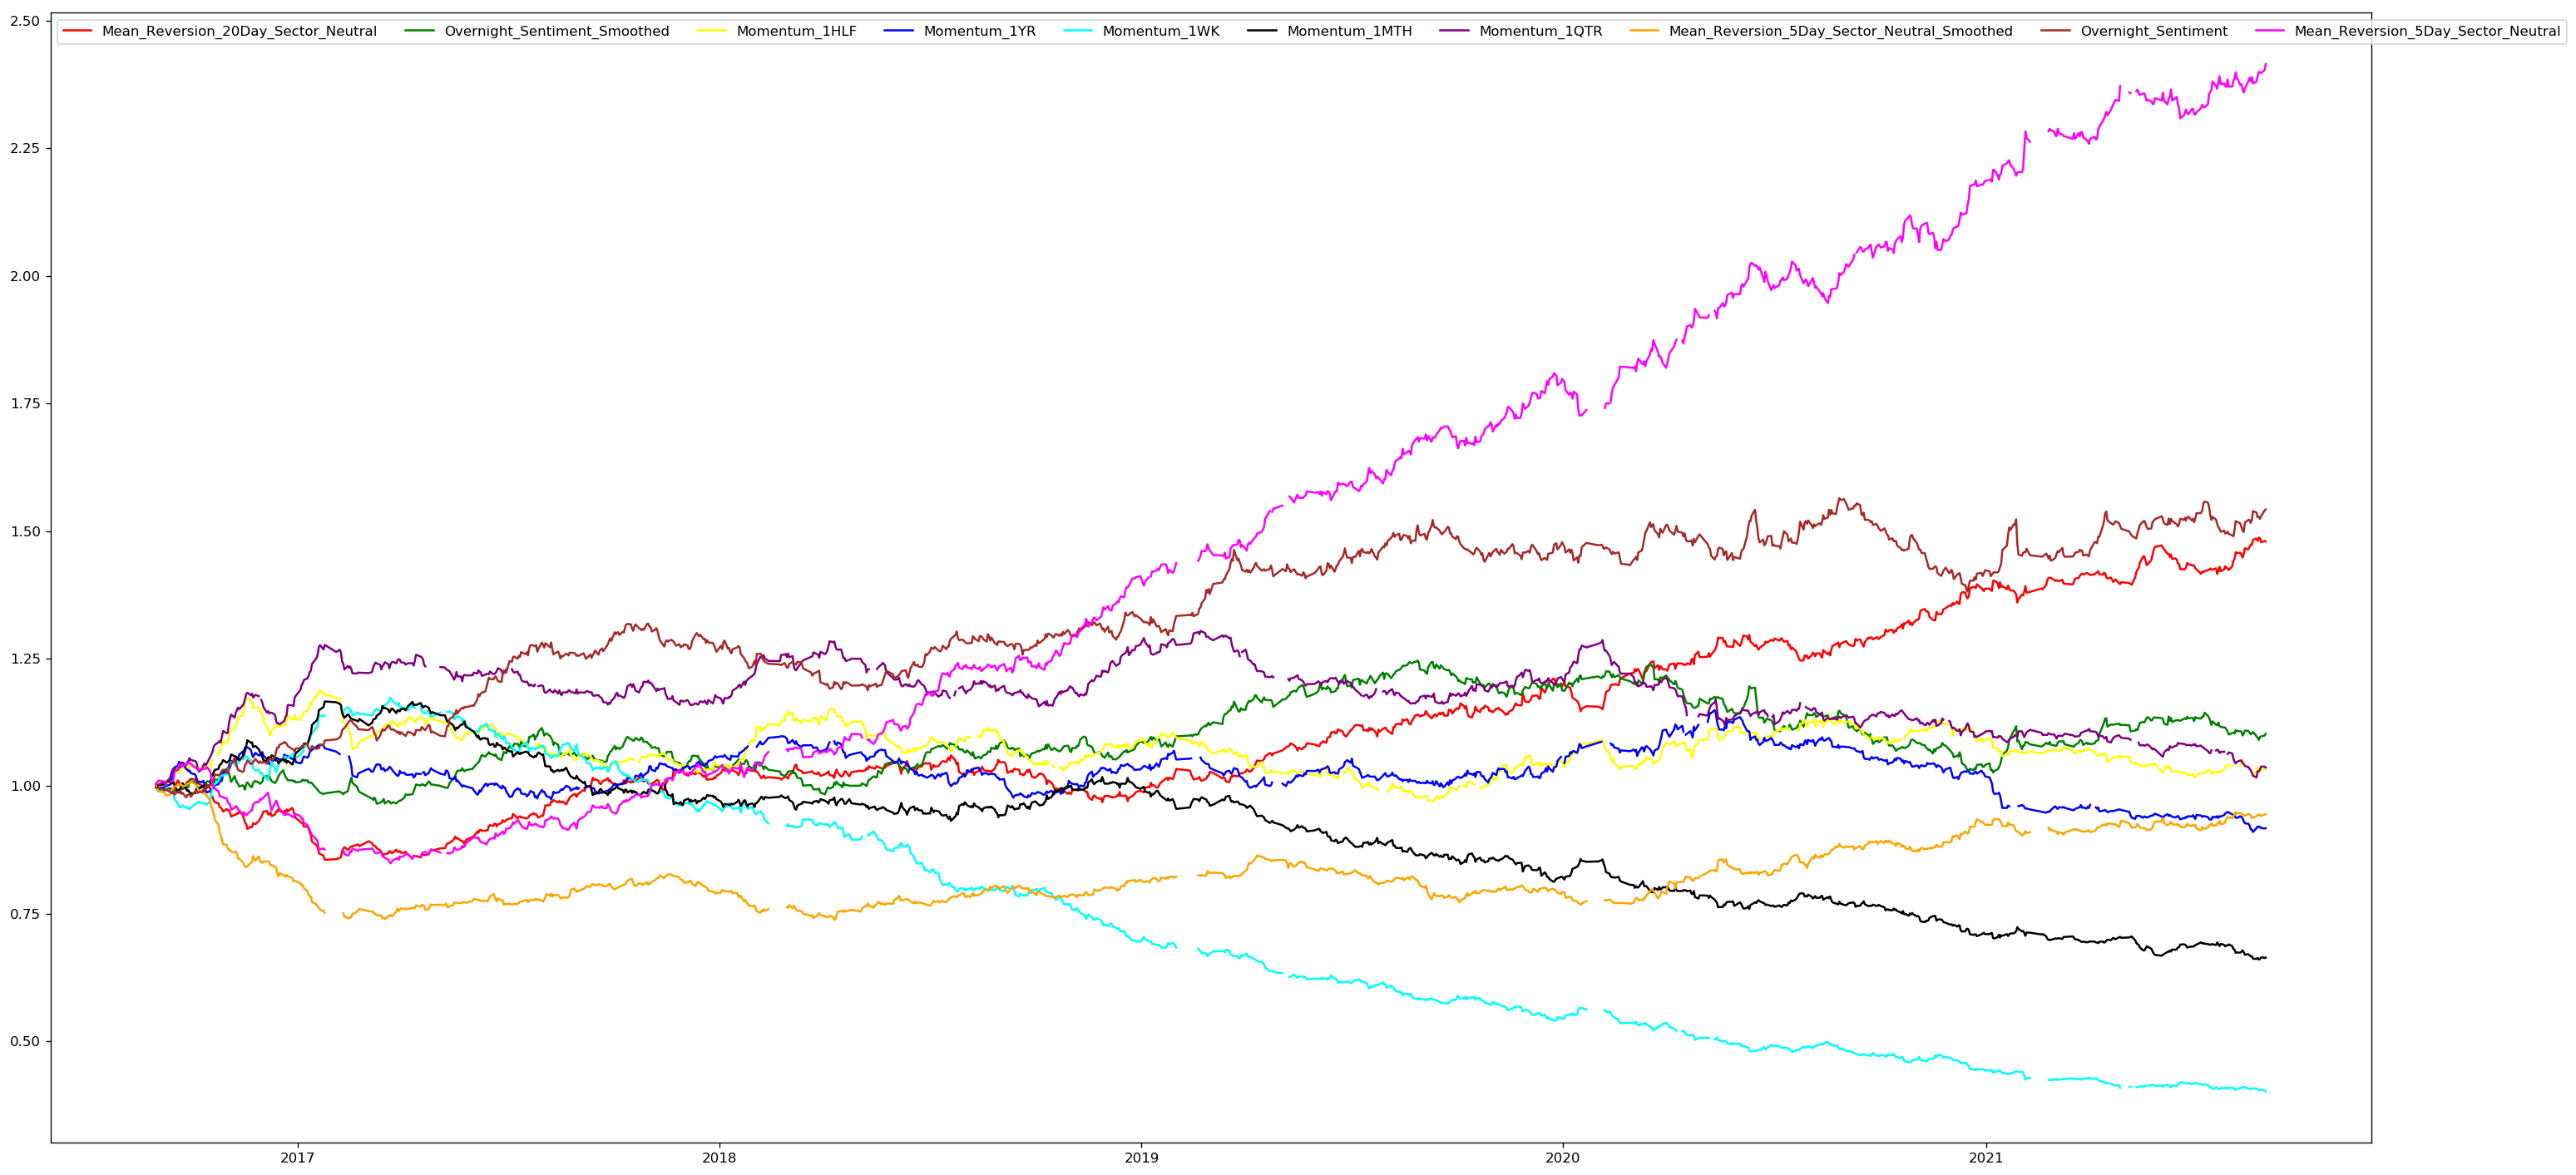

In [36]:
colors = ['red','green','yellow','blue','cyan','black','purple','orange','brown','magenta']
plt.figure(figsize=(30, 15))
for i, col in enumerate(ls_factor_returns_quantile.columns):
  plt.plot((1+ls_factor_returns_quantile[col]).cumprod(),color=colors[i])
plt.legend(ls_factor_returns_quantile.columns,loc="upper left",ncol=len(ls_factor_returns_quantile.columns))
plt.show()

In [ ]:
qr_factor_returns

Mean_Reversion_5Day_Sector_Neutral  \
factor_quantile                                       
1                                       -0.00040157   
2                                       -0.00026271   
3                                        0.00000195   
4                                       -0.00004529   
5                                        0.00070658   

                 Mean_Reversion_5Day_Sector_Neutral_Smoothed  Momentum_1HLF  \
factor_quantile                                                               
1                                                 0.00015297     0.00056935   
2                                                -0.00023473    -0.00009000   
3                                                -0.00006497    -0.00017477   
4                                                -0.00011686    -0.00019621   
5                                                 0.00026187    -0.00011178   

                 Momentum_1MNT  Momentum_1QTR  Momentum_1WK  Momentum_1YR  \
factor_quantile                                                             
1                   0.00045452     0.00073217    0.00070903    0.00024328   
2                  -0.00023573    -0.00015927   -0.00006038   -0.00001059   
3                  -0.00021815    -0.00043225    0.00001072   -0.00002635   
4                  -0.00010714    -0.00028259   -0.00025963   -0.00019239   
5                   0.00010212     0.00013579   -0.00040302   -0.00001448   

                 Overnight_Sentiment  Overnight_Sentiment_Smoothed  
factor_quantile                                                     
1                         0.00017941                    0.00019196  
2                        -0.00010564                   -0.00002600  
3                        -0.00018665                   -0.00040959  
4                        -0.00008707                   -0.00007698  
5                         0.00019858                    0.00031858

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**. 
[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

In [37]:
ls_FRA = pd.DataFrame()

#Computes autocorrelation of mean factor ranks in specified time spans.
for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

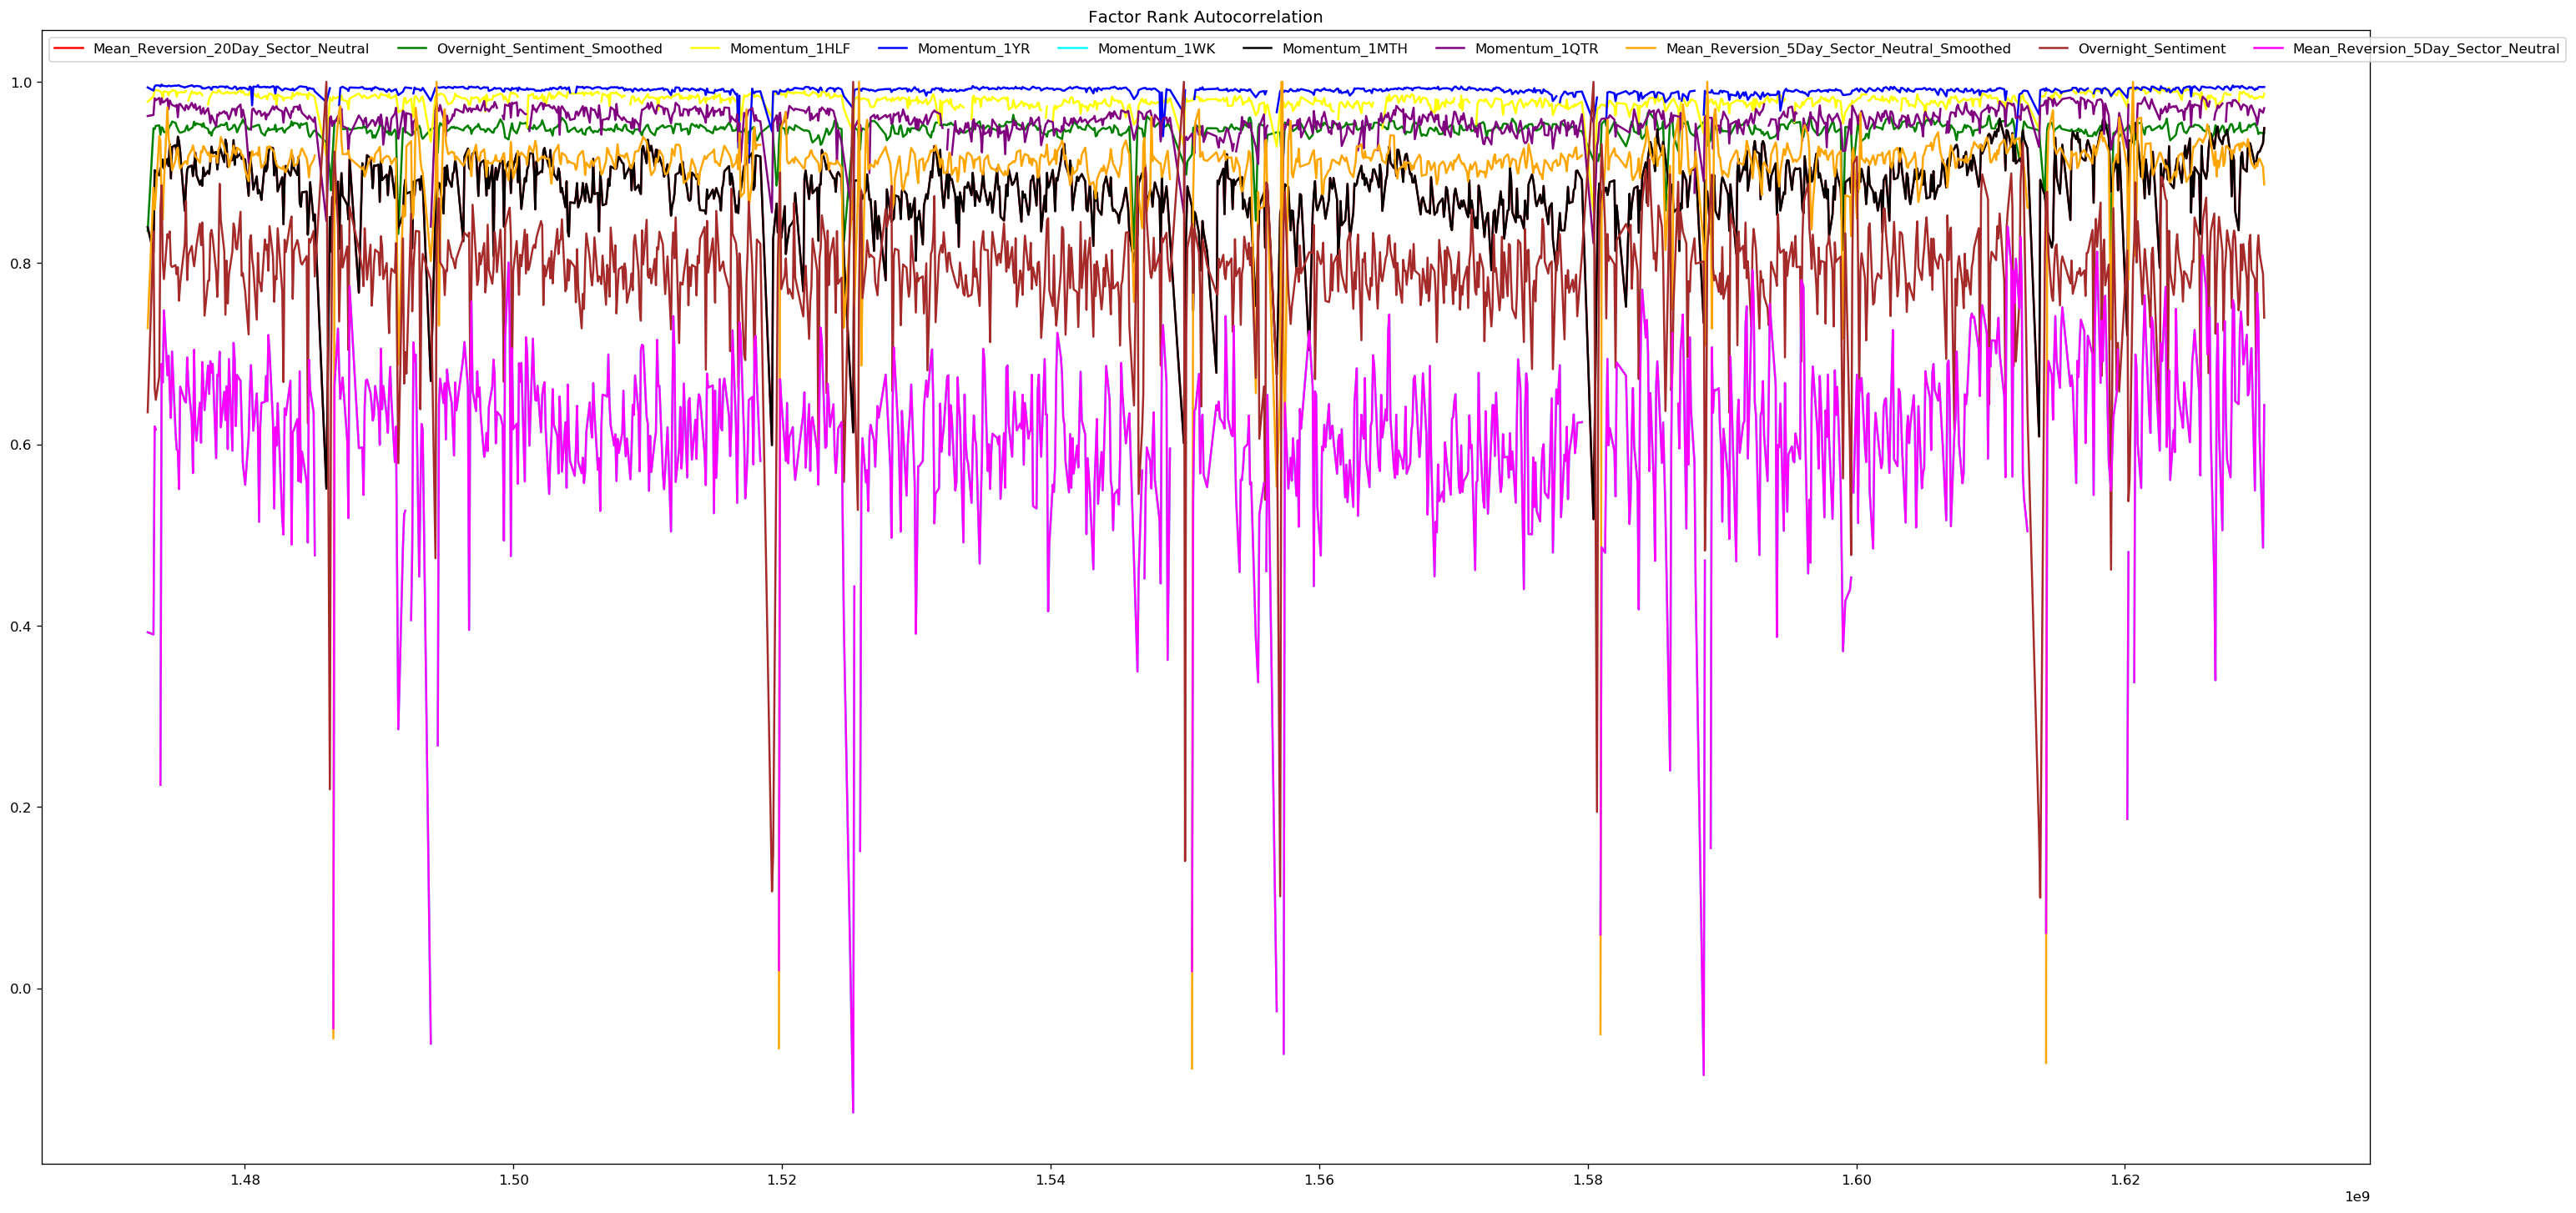

In [40]:
plt.figure(figsize=(30, 15))
for i, col in enumerate(ls_FRA.columns):
  plt.plot(ls_FRA[col],color=colors[i])
plt.title("Factor Rank Autocorrelation")
plt.legend(ls_FRA.columns,loc="upper left",ncol=len(ls_FRA.columns))
plt.show()

In [41]:
ls_FRA_clean = ls_FRA.copy()
ls_FRA_clean['dates'] = pd.to_datetime(ls_FRA.index,unit='s')
ls_FRA_clean.set_index(ls_FRA_clean['dates'],inplace=True)

In [42]:
ls_FRA_clean.drop(['dates'],axis=1,inplace=True)
ls_FRA_clean.head(2)

Mean_Reversion_20Day_Sector_Neutral  Overnight_Sentiment_Smoothed  \
dates                                                                           
2016-08-31                                  NaN                           NaN   
2016-09-02                             0.839667                      0.835431   

            Momentum_1HLF  Momentum_1YR  Momentum_1WK  Momentum_1MTH  \
dates                                                                  
2016-08-31            NaN           NaN           NaN            NaN   
2016-09-02       0.978052       0.99383      0.392727       0.839667   

            Momentum_1QTR  Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
dates                                                                    
2016-08-31            NaN                                          NaN   
2016-09-02       0.962321                                     0.728349   

            Overnight_Sentiment  Mean_Reversion_5Day_Sector_Neutral  
dates                                                                
2016-08-31                  NaN                                 NaN  
2016-09-02             0.635493                            0.392727

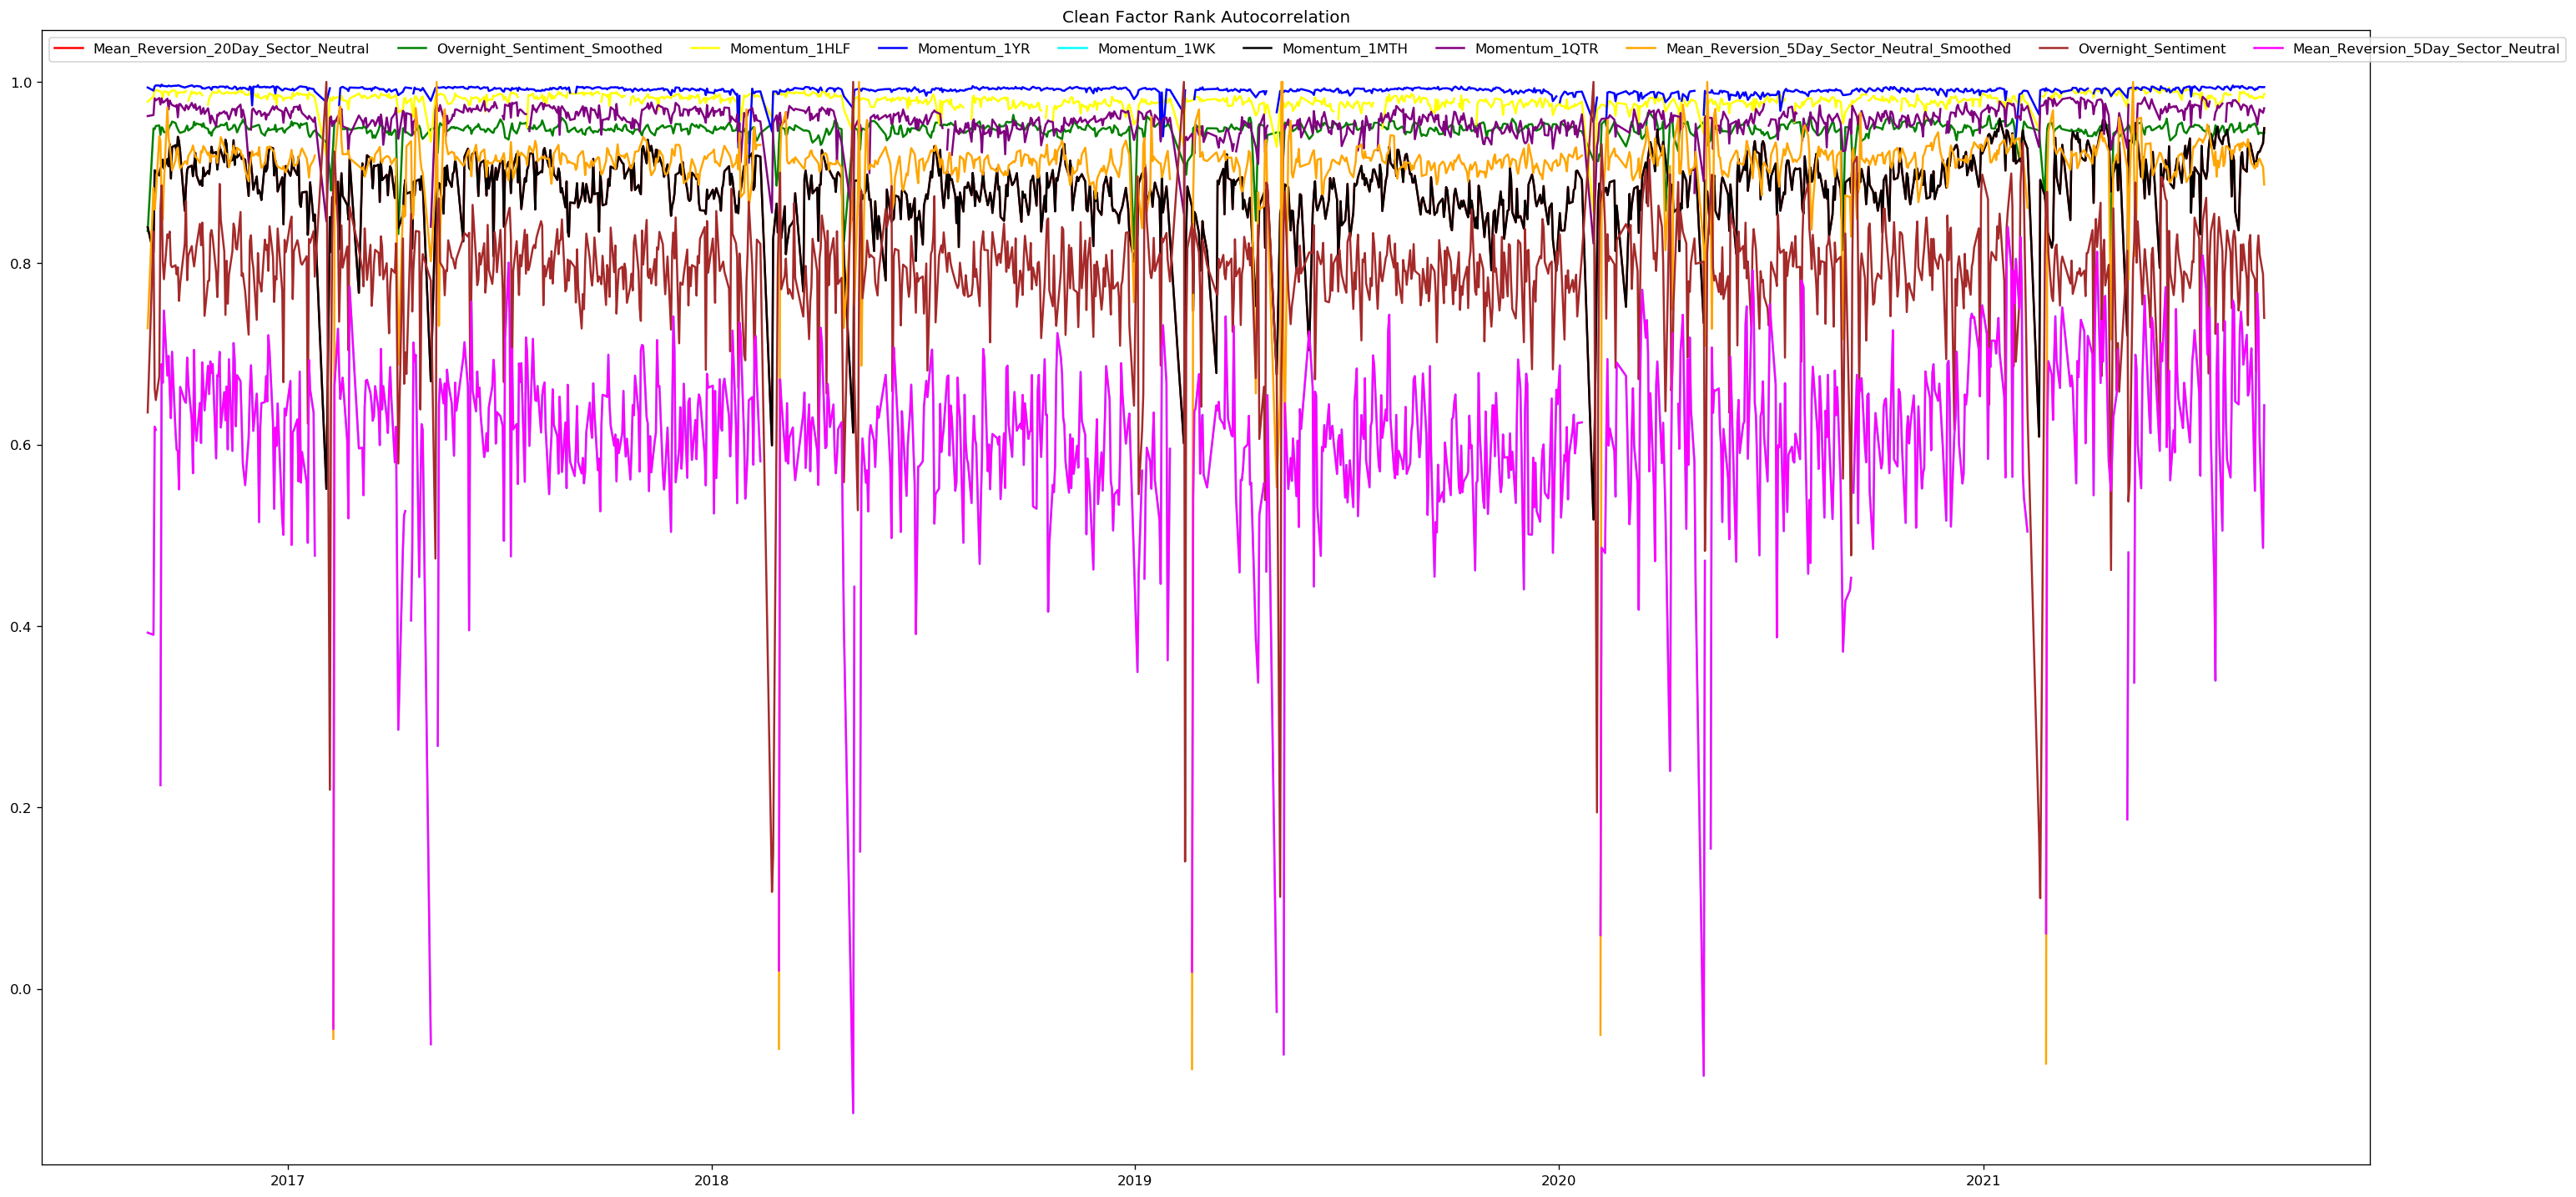

In [44]:
plt.figure(figsize=(30, 15))
for i, col in enumerate(ls_FRA_clean.columns):
  plt.plot(ls_FRA_clean[col],color=colors[i])
plt.title("Clean Factor Rank Autocorrelation")
plt.legend(ls_FRA_clean.columns,loc="upper left",ncol=len(ls_FRA_clean.columns))
plt.show()

#### Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [47]:
daily_annualization_factor = np.sqrt(252)

amf.sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_20Day_Sector_Neutral            1.44
Overnight_Sentiment_Smoothed                   0.20
Momentum_1HLF                                 -1.61
Momentum_1YR                                  -1.02
Momentum_1WK                                  -2.77
Momentum_1MTH                                 -1.44
Momentum_1QTR                                 -1.48
Mean_Reversion_5Day_Sector_Neutral_Smoothed    0.35
Overnight_Sentiment                           -0.47
Mean_Reversion_5Day_Sector_Neutral             2.77
dtype: float64

In [48]:
amf.sharpe_ratio(ls_factor_returns_quantile, daily_annualization_factor).round(2)

Mean_Reversion_20Day_Sector_Neutral            1.15
Overnight_Sentiment_Smoothed                   0.31
Momentum_1HLF                                  0.15
Momentum_1YR                                  -0.22
Momentum_1WK                                  -2.60
Momentum_1MTH                                 -1.12
Momentum_1QTR                                  0.15
Mean_Reversion_5Day_Sector_Neutral_Smoothed   -0.14
Overnight_Sentiment                            1.14
Mean_Reversion_5Day_Sector_Neutral             2.58
dtype: float64

In [49]:
all_factors.columns

Index(['Mean_Reversion_20Day_Sector_Neutral',
       'Mean_Reversion_5Day_Sector_Neutral',
       'Mean_Reversion_5Day_Sector_Neutral_Smoothed', 'Momentum_1HLF',
       'Momentum_1MTH', 'Momentum_1QTR', 'Momentum_1WK', 'Momentum_1YR',
       'Overnight_Sentiment', 'Overnight_Sentiment_Smoothed'],
      dtype='object')

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [50]:
selected_factors = all_factors.columns[[0,1]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

#reduce 9 cols by averaging them to 1, keep rows
all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1) 
alphas = all_factors[['alpha_vector']]
#alpha vector (500 rows/stocks) for 1 day in 2021 only
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]] 
alpha_vector.tail()

Selected Factors: Mean_Reversion_20Day_Sector_Neutral, Mean_Reversion_5Day_Sector_Neutral


alpha_vector
asset                          
Equity(616 [WSB])      0.390925
Equity(617 [X26])      0.465115
Equity(618 [YBM])      1.301180
Equity(619 [YEG])      0.482236
Equity(620 [YTC])      1.677837

### 3.3. Multi-factor model: Optimal Portfolio Constrained by Risk Model

We have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model.  
We'll be building the optimizer for this portfolio  
Cumulative returns of each weight scheme?

We have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model.  
We'll be building the optimizer for this portfolio  
Cumulative returns of each weight scheme?

### Three weight schemes:

<p>- alphas exposes under risk model  <br>
optimal_weights1 = cvx.Maximize(alpha_vector.values.T * weights)</p>


<p>- alphas exposes under risk model with regularization weights  <br>
optimal_weights2 = cvx.Maximize((alpha_vector.values.T*weights)-self.lambda_reg*cvx.pnorm(weights,2))</p>


<p>- alphas exposes under risk model with target weights  <br>
optimal_weights2 = cvx.Minimize(-(alpha_vector.values.T*weights)+cvx.pnorm(weights-target_weights,2))</p>

How to deal with these weights:  
    1.find the corresponding stocks related to PC  
    2.apply weight scheme to each stock  
    3.compute anual returns & compare to index??  

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

With the `OptimalHoldings` class implemented, let's see the weights it generates.

In [ ]:
#find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector) return optimum weights
optimal_weights = mff.OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], 
                                         risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


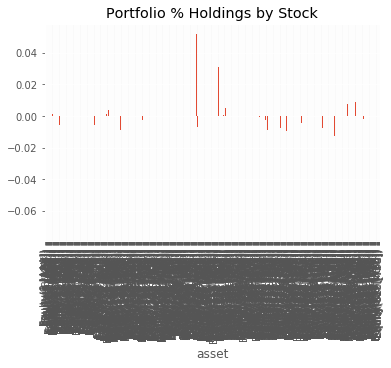

In [ ]:
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()

Yikes. It put most of the weight in a few stocks.

In [ ]:
factor_betas_weight = mff.get_factor_exposures(risk_model['factor_betas'], optimal_weights)
factor_betas_weight

0
0  -0.00358588
1   0.00086352
2  -0.00077699
3  -0.00040435
4  -0.00006326
5  -0.00168441
6   0.00122193
7   0.00058541
8   0.00267347
9   0.00039721
10  0.00149057
11 -0.00106908
12  0.00234249
13  0.00214664
14  0.00050222
15  0.00018699
16  0.00223662
17  0.00295250
18  0.00445333
19  0.00074099

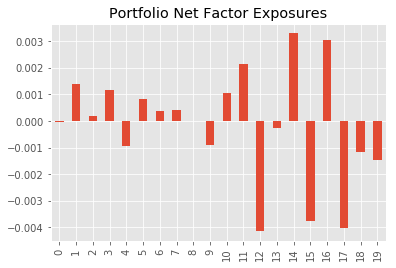

In [ ]:
factor_betas_weight.plot.bar(title='Portfolio Net Factor Exposures',legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


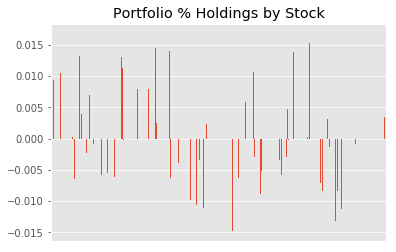

In [ ]:
#.find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector) return optimum weights
optimal_weights_1 = mff.OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, 
                  risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Nice. Well diversified.

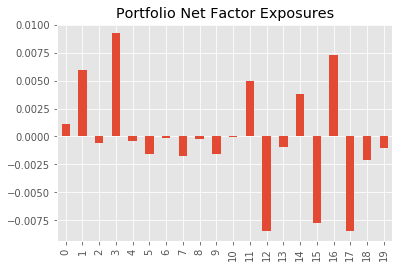

In [ ]:
mff.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


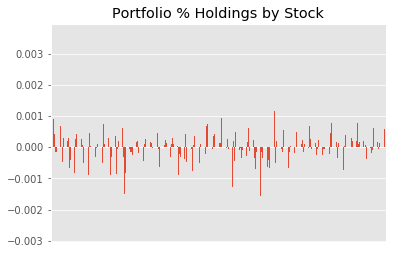

In [ ]:
#__init__(self,lambda_reg=0.5,risk_cap=0.05,factor_max=10.0,factor_min=-10.0,weights_max=0.55,weights_min=-0.55)
#.find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector) return optimum weights
optimal_weights_2 = mff.OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector,risk_model['factor_betas'],risk_model['factor_cov_matrix'], 
                            risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

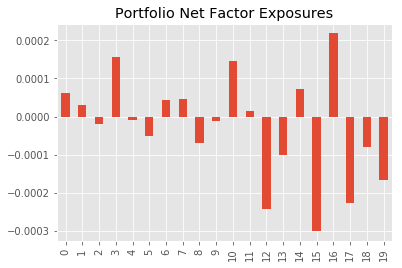

In [ ]:
mff.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

<h2>4. Conclusions & Recommendations</h2>